# OptiCoffee

El Área de Producción de **OptiCoffee** lo ha contactado para realizar la **planeación de la producción de toneladas de café para los próximos 'n' meses**. El Área de Producción debe decidir **cuántas toneladas de café producir mensualmente** con el fin de **satisfacer la demanda al final de cada mes**.

Actualmente, OptiCoffee cuenta con un **inventario de 'n' toneladas** de café almacenadas en su bodega. Al final de cada mes, el café que no haya sido utilizado debe ser **almacenado en inventario** y puede ser utilizado para satisfacer la demanda de los siguientes meses.

La **Tabla 1** presenta los **costos mensuales de producción y almacenamiento** de una tonelada de café, así como la **demanda mensual** de toneladas de café que tiene que satisfacer OptiCoffee. Es importante tener en cuenta que los **costos y la demanda varían dependiendo del mes**, estos son a modo de ejemplo.

Naturalmente, el Área de Producción de OptiCoffee desea **minimizar sus costos totales a lo largo del horizonte de planeación** (i.e., 12 meses).



**Tabla 1.** Costos mensuales de producción y almacenamiento de una tonelada de café y demanda mensual

| Mes                                               | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  |
| ------------------------------------------------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Costo de producción** (millones de COP/Ton)     | 5   | 5   | 5   | 10  | 6   | 10  | 9   | 9   | 6   | 10  | 7   | 8   |
| **Costo de almacenamiento** (millones de COP/Ton) | 5   | 4   | 4   | 5   | 3   | 1   | 3   | 5   | 3   | 3   | 4   | 5   |
| **Demanda** (Ton)                                 | 522 | 554 | 557 | 519 | 476 | 475 | 462 | 452 | 465 | 422 | 512 | 596 |



**Objetivo**

Para planear la producción de OptiCoffee, usted desarrollará un **modelo de optimización**.

## Datos

In [166]:
"""
===============================================================================
Preparación del entorno de planeación de inventarios para experimentación
──────────────────────────────────────────────────────────────────────────────
Este script crea una instancia sintética de un problema de inventarios de
múltiples períodos a partir de un generador externo (`InsInventory.py`) ubicado
en un directorio de instancias personalizado. El objetivo es disponer de datos
estructurados (demanda por período, etc.) sobre los cuales se puedan aplicar
posteriormente políticas de reabastecimiento, simulaciones, heurísticas o
modelos de optimización.

Estructura general
-------------------------------------------------------------------------------
  1. Importar librerías requeridas.
  2. Ajustar la ruta de búsqueda de módulos para acceder a instancias externas.
  3. Generar datos sintéticos de demanda para un horizonte de planificación
     definido por número de períodos.
  4. Calcular un inventario inicial (I_0) como fracción conservadora de la
     demanda mínima observada en el horizonte.
  5. Inspeccionar / visualizar los datos generados.
  6. Inicializar contenedor para registrar resultados de algoritmos.
===============================================================================
"""

# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================
import time                       # medición de tiempos de ejecución (uso futuro)

import sys                        # manipulación del path de importación
import os                         # utilidades de sistema de archivos

# ============================================================================
# 2. CONFIGURACIÓN DEL PATH PARA ACCESO A INSTANCIAS EXTERNAS
# ============================================================================
# Agrega la carpeta '../Instances' (relativa a este script/notebook) al sys.path
# para que Python pueda encontrar y cargar el generador de datos de inventarios.
sys.path.append(os.path.abspath("../Instances"))

# ============================================================================
# 3. IMPORTAR GENERADOR DE DATOS DE INVENTARIO
# ============================================================================
# `generar_datos` crea una instancia sintética con variables por período (p.ej.,
# demanda d_t). El parámetro `num_periodos` define la longitud del horizonte.
from InsInventory import generar_datos, plot_plan_produccion

# ============================================================================
# 4. CREAR ENTORNO / INSTANCIA SINTÉTICA DE PLANEACIÓN
# ============================================================================
# Definir la longitud del horizonte de planeación (número de períodos, p.ej. meses).
horizonte_planeacion = generar_datos(num_periodos=6)

# ============================================================================
# 5. ESTABLECER INVENTARIO INICIAL
# ============================================================================
# Como punto de partida sencillo, fijamos el inventario inicial (I_0) como 25%
# de la demanda mínima observada a lo largo del horizonte. Se aplica `int()` para
# trabajar con inventarios enteros (redondeo hacia abajo).
I_0 = int(min(horizonte_planeacion['d_t']) * 0.25)

# ============================================================================
# 6. ESTRUCTURA PARA REGISTRAR RESULTADOS
# ============================================================================
# Se usará para acumular métricas de distintos enfoques (heurísticas, políticas,
# modelos de optimización, simulaciones Monte Carlo, etc.) aplicados al horizonte.
resultados = []

# Mostrar el DataFrame / estructura generada para inspección en entornos
# interactivos (Jupyter, IPython). En un script puro, esto no imprime nada a
# menos que se envuelva en `print(...)`.
horizonte_planeacion

t  Mes    c_t   h_t  d_t Clasif_c Clasif_h Demanda_rel
t                                                        
1  1  ENE   7.00  3.39    4    Medio    Medio        Baja
2  2  FEB   5.68  1.20    6   Barato   Barato        Alta
3  3  MAR  10.59  5.25    6     Caro     Caro        Alta
4  4  ABR   5.72  4.10    6   Barato    Medio        Alta
5  5  MAY   7.11  3.03    4    Medio    Medio        Baja
6  6  JUN   6.47  3.89    5    Medio    Medio        Baja

## Optimización (MIP)

### Formulación

#### Conjuntos

$$
M \quad \text{: Conjunto de meses}
$$

#### Parámetros

$$
c_t \quad \text{: Costo de producir una tonelada de café en el mes } t \in M
$$

$$
h_t \quad \text{: Costo de almacenar una tonelada de café en el mes } t \in M
$$

$$
d_t \quad \text{: Demanda de café en el mes } t \in M
$$

$$
I^0 \quad \text{: Inventario inicial (toneladas)}
$$


#### Variables de decisión

$$
x_t \quad \text{: Toneladas de café a producir en el mes } t \in M
$$

$$
I_t \quad \text{: Inventario de toneladas de café al final del mes } t \in M
$$


#### Modelo en Palabras

**Minimizar:**

> Costos de producción + Costos de almacenamiento

**Sujeto a:**

* Modelar el inventario para el primer mes
* Modelar el inventario para los demás meses
* Naturaleza de las variables

#### Modelo Matemático

Minimizar:

$$
\sum_{t \in M} (c_t x_t + h_t I_t) \tag{1}
$$

Sujeto a:

Inventario en el primer mes:

$$
I_1 = I^0 + x_1 - d_1 \tag{2}
$$

Inventario para los meses siguientes:

$$
I_t = I_{t-1} + x_t - d_t, \quad \forall t \in M \mid t > 1 \tag{3}
$$

Naturaleza de las variables:

$$
x_t, I_t \geq 0, \quad \forall t \in M \tag{4}
$$

#### Notas

* (1) minimiza los costos de producción más los costos de almacenamiento.
* (2) modela el inventario para el primer mes.
* (3) modela el inventario para los demás meses.
* (4) describe la naturaleza de las variables.


In [167]:
# ============================================================================
# Extraer parámetros de la instancia de inventario a estructuras Python simples
# ============================================================================
# M: períodos del horizonte (índices del DataFrame)
M = list(horizonte_planeacion.index)

# c_t: costo de compra/producción por período
c = dict(horizonte_planeacion['c_t'].squeeze())

# h_t: costo de mantenimiento (holding) por período
h = dict(horizonte_planeacion['h_t'].squeeze())

# d_t: demanda esperada por período
d = dict(horizonte_planeacion['d_t'].squeeze())


### Modelo

In [168]:
import pulp as lp

def optimizacion_inventario(M, c, h, d, I_0=0):
    """
    Modelo de inventario multiperíodo (minimización de costo total).
    Params:
        M   : lista de períodos (índices, se asume 1 incluido).
        c   : dict[t] costo de compra/producción en t.
        h   : dict[t] costo de mantener inventario al final de t.
        d   : dict[t] demanda en t.
        I_0 : inventario inicial previo al período 1.
    Returns:
        model : modelo PuLP resuelto.
        x     : vars de orden/producción por período.
        I     : vars de inventario final por período.
    """
    # Crear modelo
    model = lp.LpProblem("OptiCoffi", lp.LpMinimize)

    # Variables: decisiones de pedido y nivel de inventario
    x = {t: lp.LpVariable(f'x_{t}', lowBound=0, cat=lp.LpInteger) for t in M}
    I = {t: lp.LpVariable(f'I_{t}', lowBound=0, cat=lp.LpInteger) for t in M}
    
    # Objetivo: costo compra + costo mantenimiento
    model += lp.lpSum(c[t] * x[t] + h[t] * I[t] for t in M)

    # Balance inventario
    for t in M:
        if t == 1:
            model += I[1] == I_0 + x[1] - d[1]  # usa inventario inicial
        else:
            model += I[t] == I[t-1] + x[t] - d[t]
    
    # Resolver
    solver = lp.getSolver('PULP_CBC_CMD', msg=False)
    model.solve(solver)

    # Estado del solver
    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')

    return model, x, I


El optimizador llegó a una solución: Optimal.

Tiempo de ejecución: 0.044320 s
FO (valor total): 184.27 (Producción) + 7.2 (Inventario) = 191.47
Cantidad de toneladas pedidas (valor total): 30.0.
Cantidad de toneladas en inventario (valor total): 7.0.


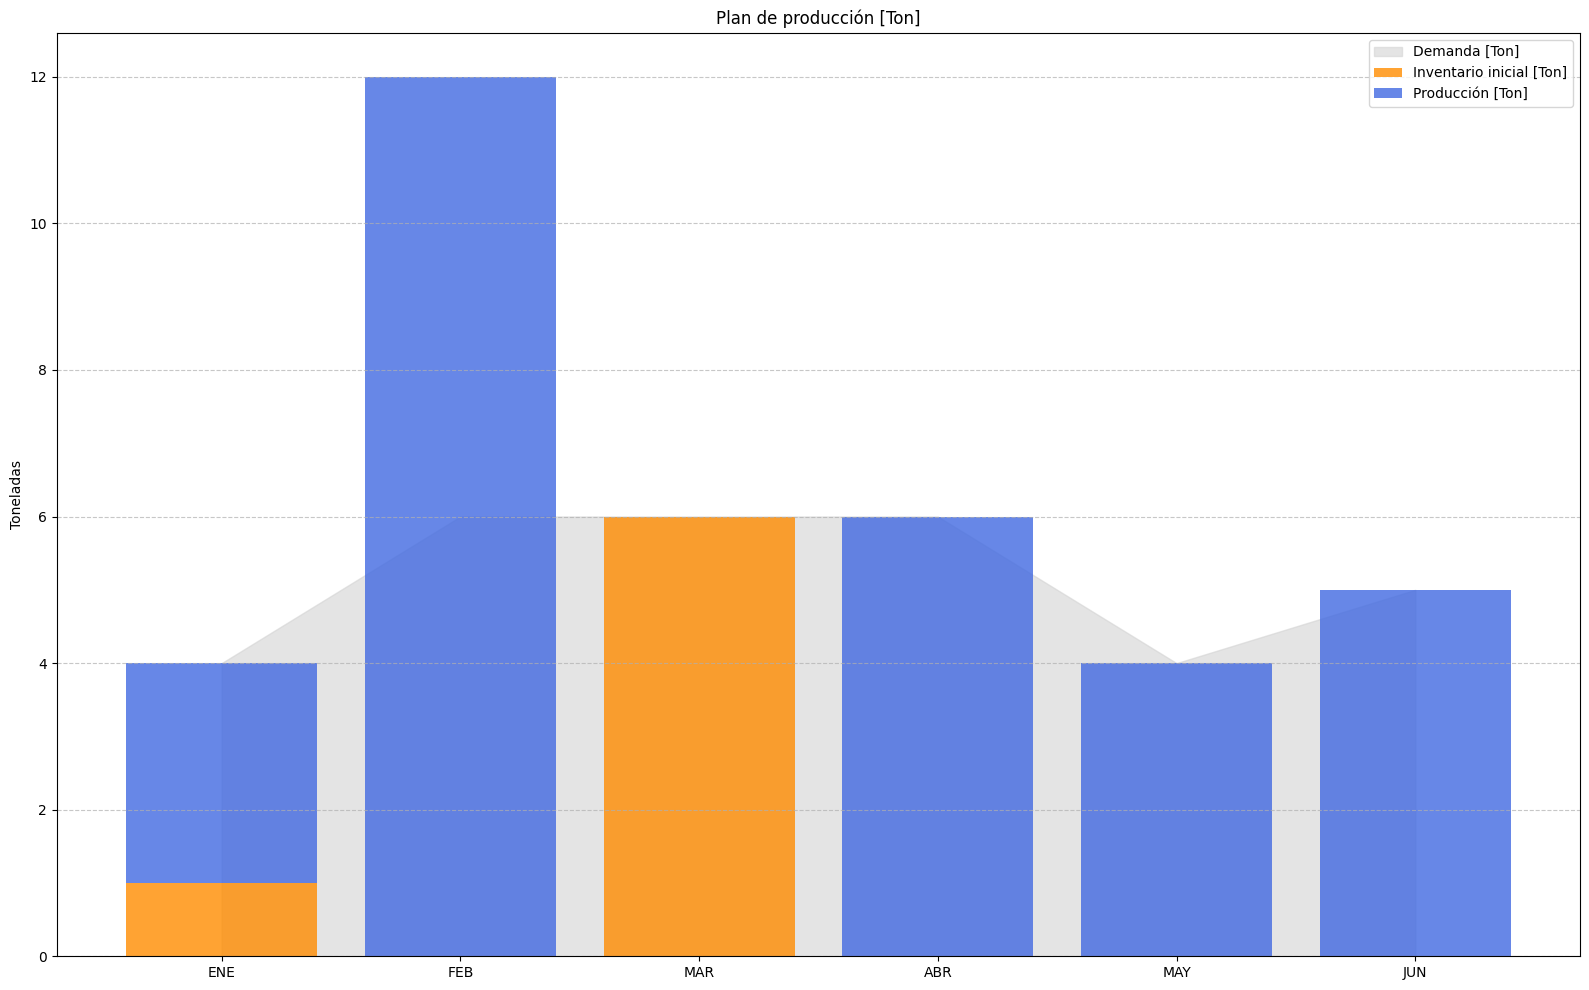

In [169]:
# ============================================================================
# Resolver modelo de inventario y registrar métricas de desempeño
# ============================================================================

# 1. Cronometrar solución del modelo
t0 = time.perf_counter()
model, x, I = optimizacion_inventario(M, c, h, d, I_0)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# 2. Objetivo óptimo (costo total)
obj_lp = round(lp.value(model.objective), 3)

# 3. Extraer valores de variables
produccion = {t: x[t].varValue for t in M}

#    Nota: Se reporta inventario inicial en período 1 y luego inventarios
#    resultantes del modelo desplazados a t+1 (para reflejar "fin de t").
inventario = {1: I_0, **{t + 1: I[t].varValue for t in M}}

# 4. Desglose de costos
cost_produccion = round(sum(x[t].varValue * c[t] for t in M), 3)
cost_inventario = round(sum(I[t].varValue * h[t] for t in M), 3)

# 5. Reporte
print(f'FO (valor total): {cost_produccion} (Producción) + {cost_inventario} (Inventario) = {obj_lp}')
print(f'Cantidad de toneladas pedidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario.values())}.')
plot_plan_produccion(M, d, produccion, inventario)

# 6. Registrar resultados
resultados.append({
    "Método"             : "LP",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario.values()),
    "Tiempo (s)"         : elapsed
})


## Programación Dinámica

### Algoritmos de Solución

In [170]:
# ============================================================================
# Rutas adicionales para módulos de Programación Dinámica (DP)
# ============================================================================
sys.path.append(os.path.abspath("../DP/Env"))         # entorno de inventario
sys.path.append(os.path.abspath("../DP/Algorithms/")) # algoritmos DP
sys.path.append(os.path.abspath("../DP/Visual/"))     # utilidades de visualización

# ============================================================================
# Importar entorno de inventario (MDP)
# ============================================================================
from Inventory import InventoryEnv

# ============================================================================
# Algoritmos de DP
# ============================================================================
from value_iteration import value_iteration
from policy_evaluation import policy_evaluation
from policy_iteration import policy_iteration

# ============================================================================
# Herramientas de visualización / análisis de políticas y valores
# ============================================================================
from value_states import value_states_visual
from policy_dag import draw_policy_dag


#### Datos

In [171]:
# ============================================================================
# 1. Datos determinísticos por período (listas alineadas con M)
# ============================================================================
demand         = list(d.values())  # demanda por período
cost_producir  = list(c.values())  # costo de producción/compra por período
cost_almacenar = list(h.values())  # costo de mantenimiento por período

# ============================================================================
# 2. Parámetros del almacén / entorno MDP de inventario
# ============================================================================
capacity        = int(sum(demand) / 2)  # capacidad (heurística: 50% de la demanda total)
start_inventory = I_0                   # inventario inicial

# ============================================================================
# 3. Instanciar entorno de inventario y mostrar resumen
# ============================================================================
env = InventoryEnv(demand, cost_producir, cost_almacenar, capacity, start_inventory)
print(env)


InventoryEnv(Horizonte = 6, Capacidad = 15, #_Estados = 112)


#### Policy Evaluation


Tiempo de ejecución: 0.000304 s
FO (valor total): 213.73 (Producción) + 0.0 (Inventario) = 213.73
Cantidad de toneladas pedidas (valor total): 30.
Cantidad de toneladas en inventario (valor total): 1.


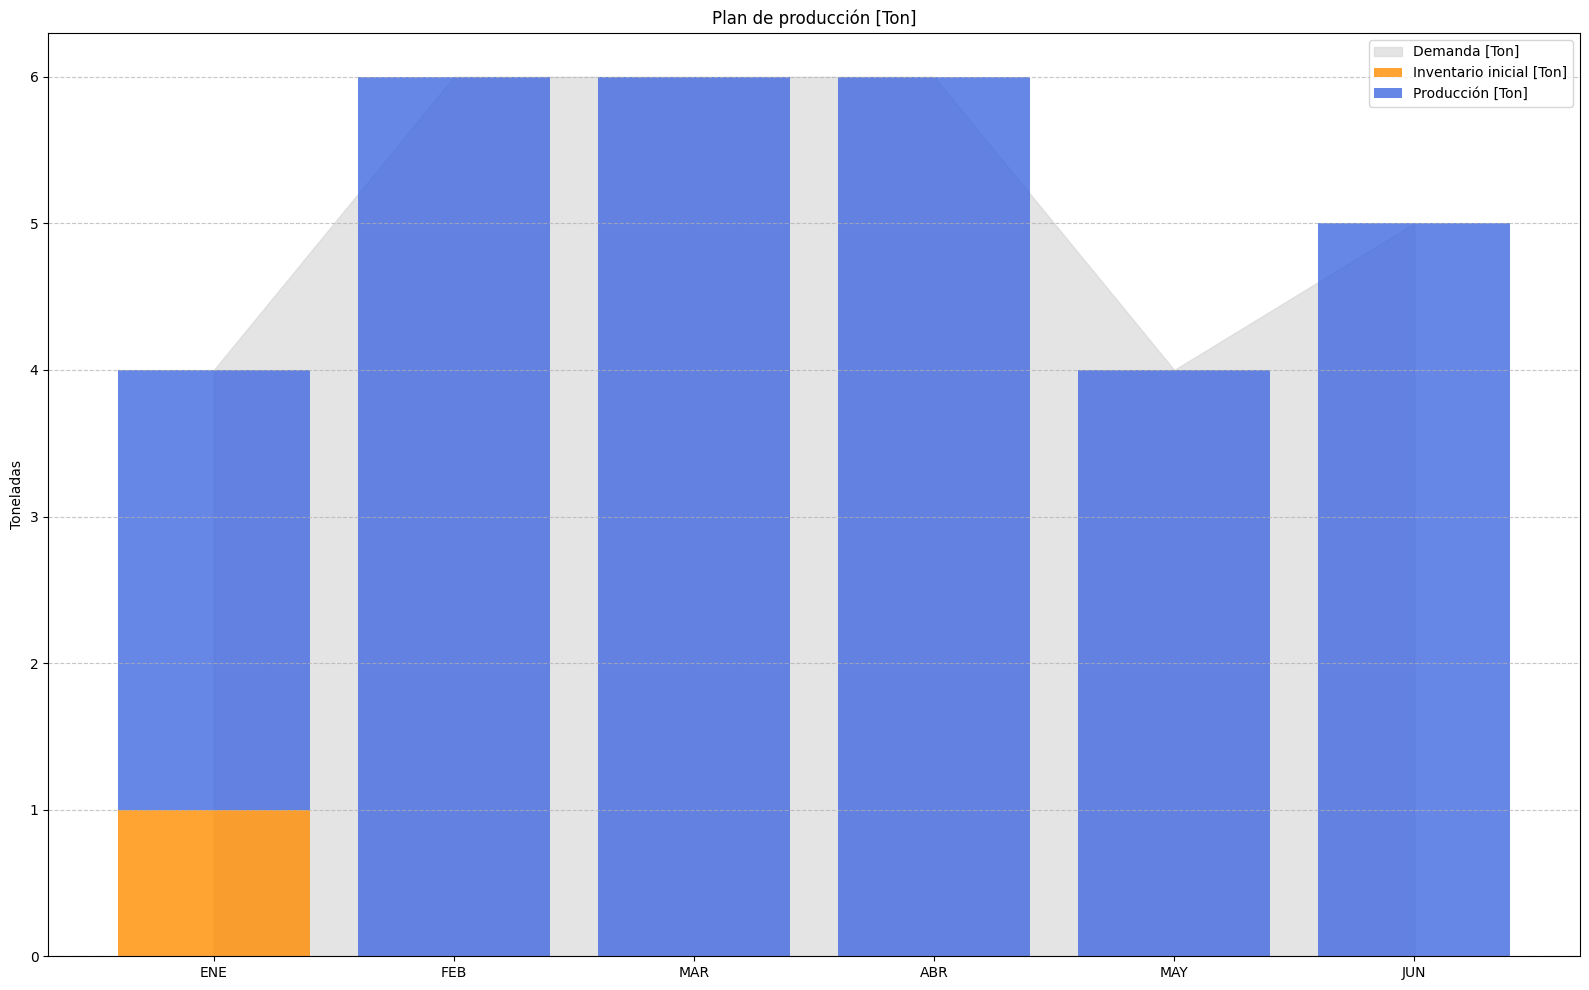

In [172]:
# ============================================================================
# Política determinista: ordenar justo lo faltante para cubrir demanda en t
# key = (t, S) donde S es inventario disponible; acción = max(0, demanda - S)
# ============================================================================
propose_policy = {
    (t, S): max(0, env.demand[t] - S)
    for t in range(env.n)
    for S in range(env.capacity + 1)
}

# Copia explícita (por si se modifica aparte)
policy = propose_policy.copy()

# ============================================================================
# Evaluar la política propuesta
# ============================================================================
t0 = time.perf_counter()
V = policy_evaluation(env, propose_policy)  # función de valor bajo política fija
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# ============================================================================
# Reporte de costos y trayectorias inducidos por la política
# (nota: reutiliza nombre obj_lp aunque aquí proviene del entorno, no del LP)
# ============================================================================
obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(policy)

# Registrar en tabla de resultados
resultados.append({
    "Método"             : "Policy evaluation",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})


#### Policy Iteration


Tiempo de ejecución: 0.001052 s
FO (valor total): 184.27 (Producción) + 7.2 (Inventario) = 191.47
Cantidad de toneladas pedidas (valor total): 30.
Cantidad de toneladas en inventario (valor total): 7.


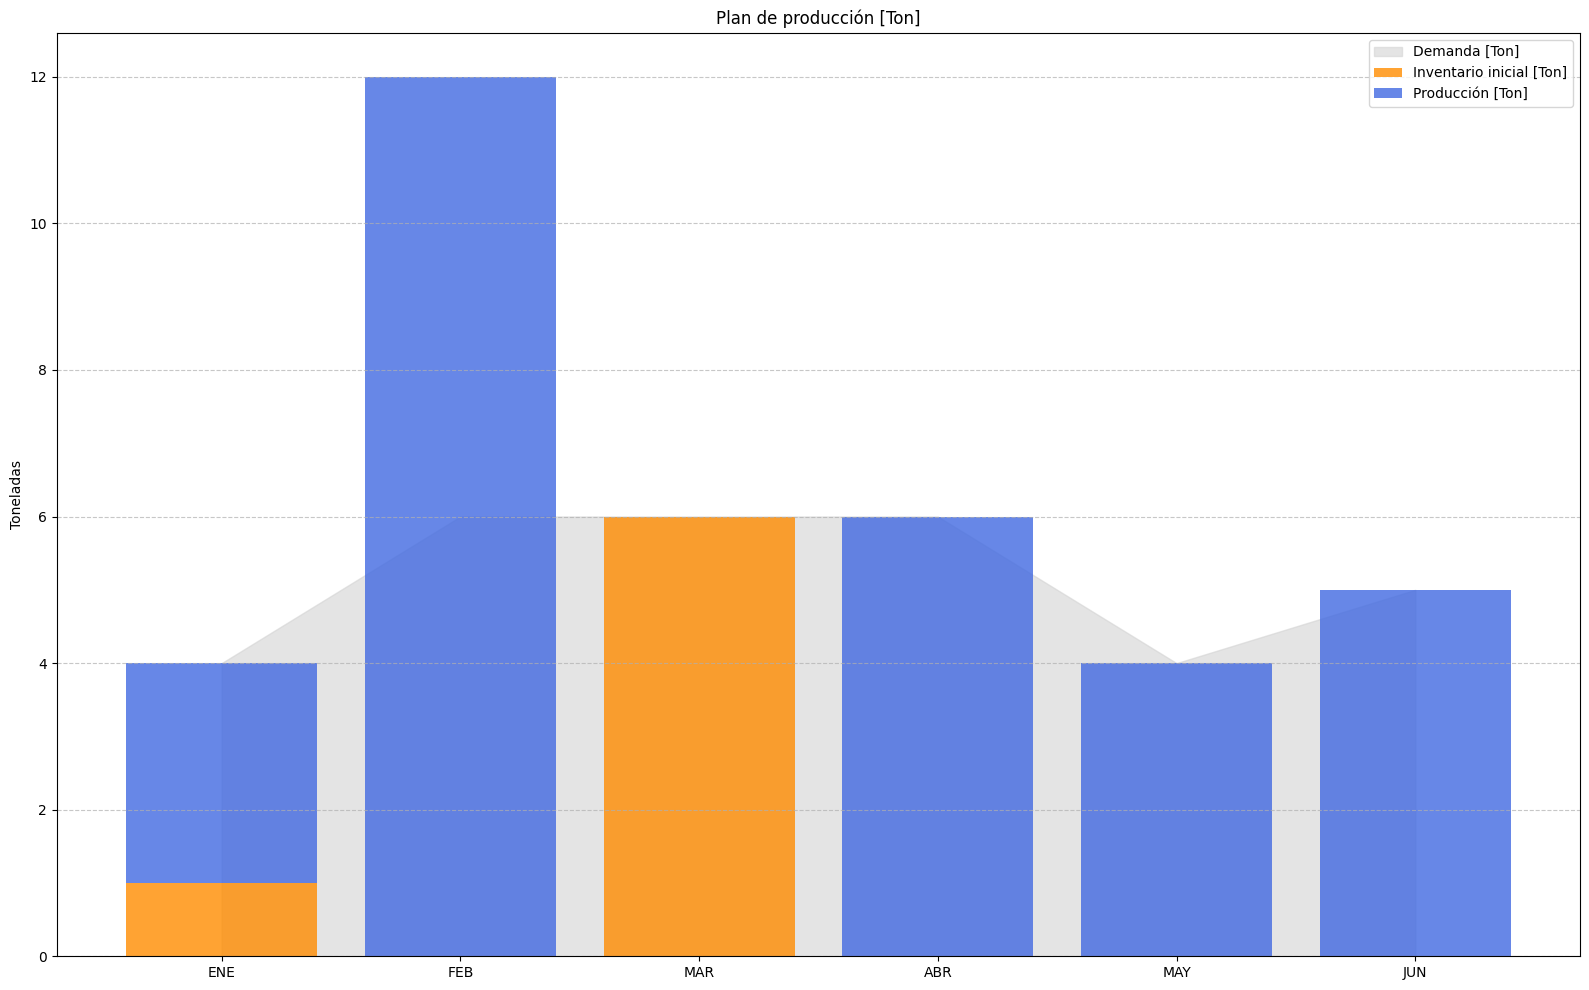

In [173]:
# ============================================================================
# Iteración de políticas: mejorar la política inicial hasta converger
# ============================================================================
t0 = time.perf_counter()
star_policy, V_star = policy_iteration(env, policy)  # retorna política mejorada y valores
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# ============================================================================
# Costos inducidos por la política resultante (star_policy)
# ============================================================================
obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(star_policy)

# Registrar resultados comparables
resultados.append({
    "Método"             : "Policy iteration",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})


#### Value Iteration


Tiempo de ejecución: 0.003388 s
FO (valor total): 184.27 (Producción) + 7.2 (Inventario) = 191.47
Cantidad de toneladas pedidas (valor total): 30.
Cantidad de toneladas en inventario (valor total): 7.


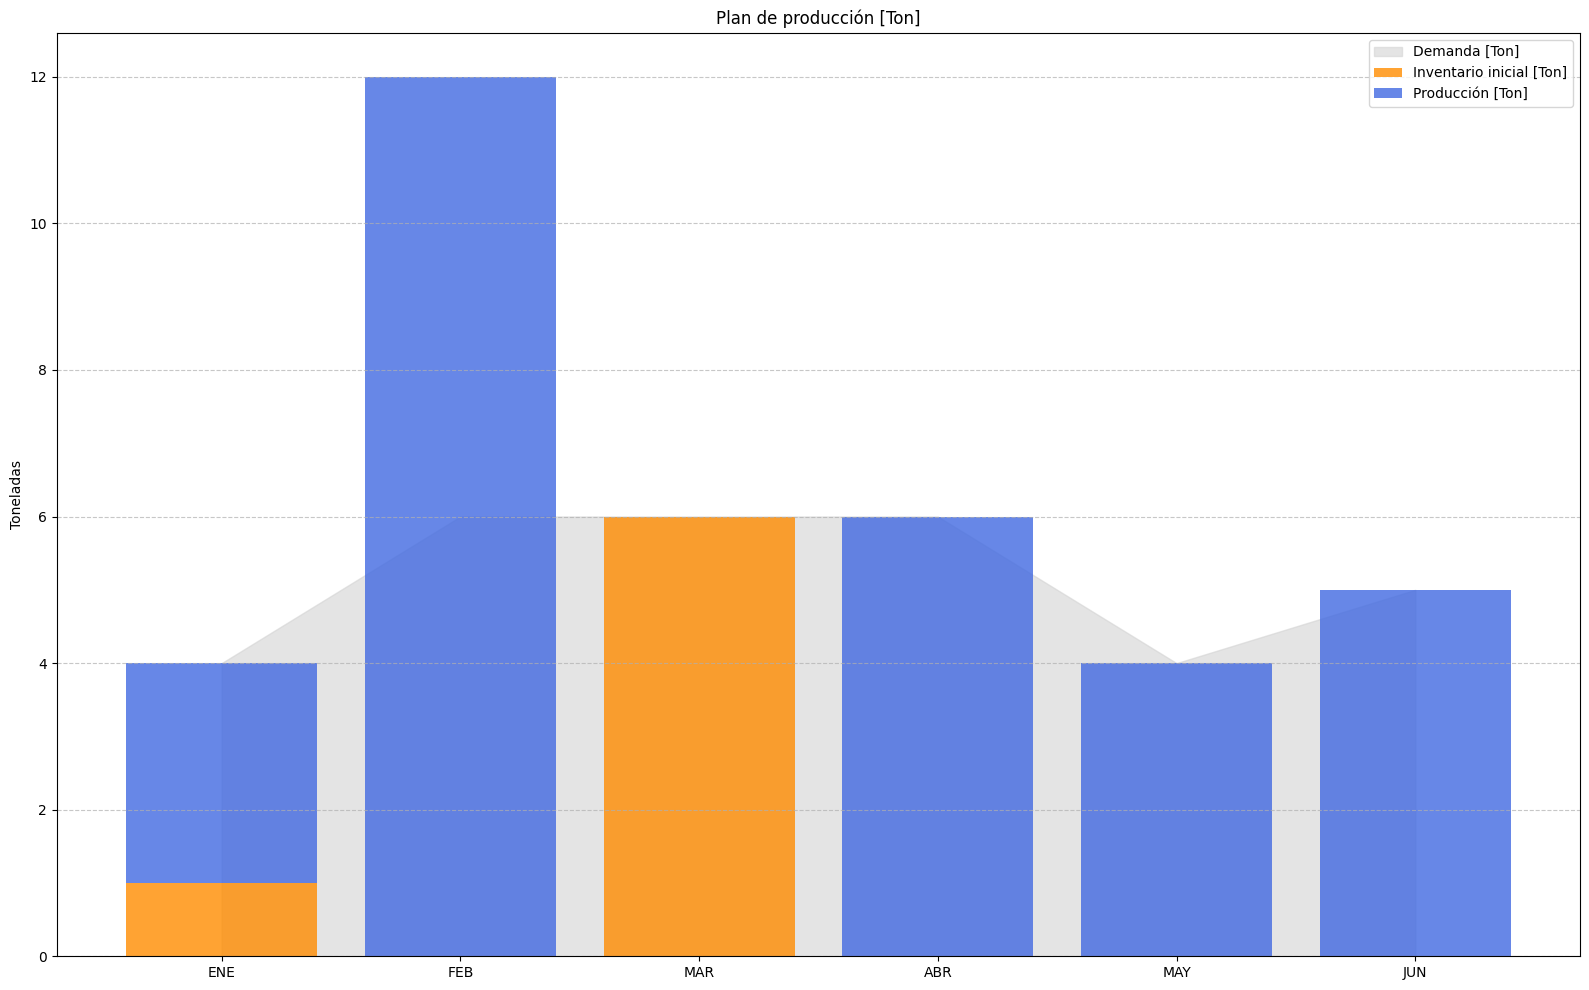

In [174]:
# ============================================================================
# Iteración de valores: resolver el MDP para obtener política óptima
# ============================================================================
t0 = time.perf_counter()
opt_policy, V_opt = value_iteration(env)  # política óptima y valores por estado
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# ============================================================================
# Costos inducidos por la política óptima
# ============================================================================
obj_lp, costos_prod, costos_inv, produccion, inventario, trayecto = env.report_from_policy(opt_policy)

# Registrar resultados
resultados.append({
    "Método"             : "Value iteration",
    "Costo Total"        : obj_lp,
    "Costo producir"     : sum(costos_prod),
    "Costo inventario"   : sum(costos_inv),
    "Ton pedidas (total)": sum(produccion),
    "Inventario(total)"  : sum(inventario),
    "Tiempo (s)"         : elapsed
})


### Visualización

#### Value Functions

Policy Evaluation


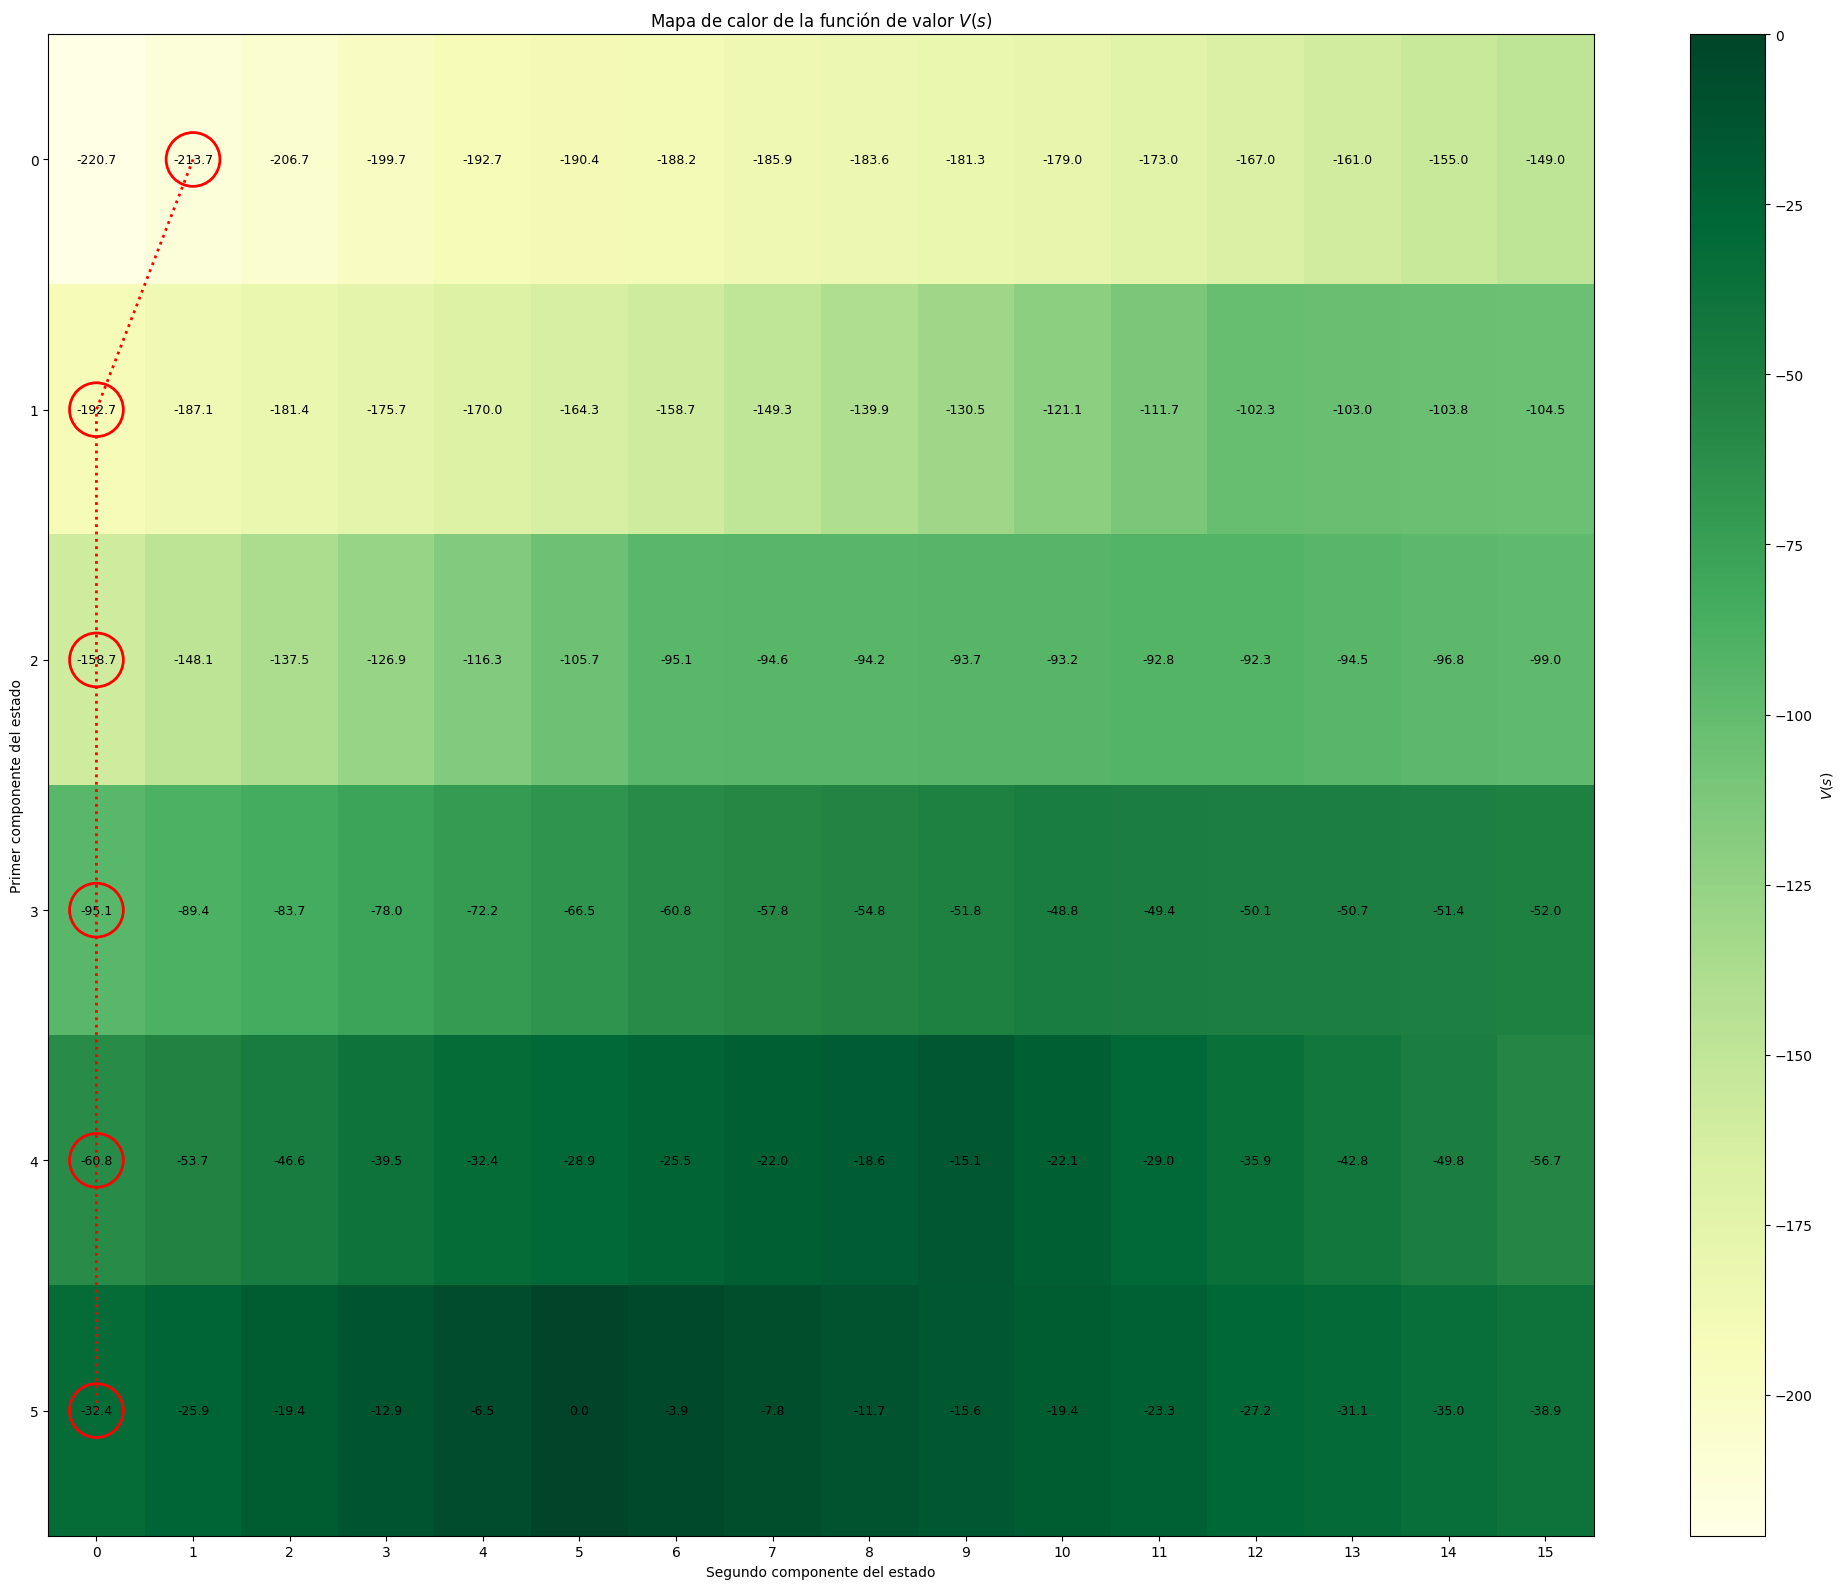


Policy Iteration


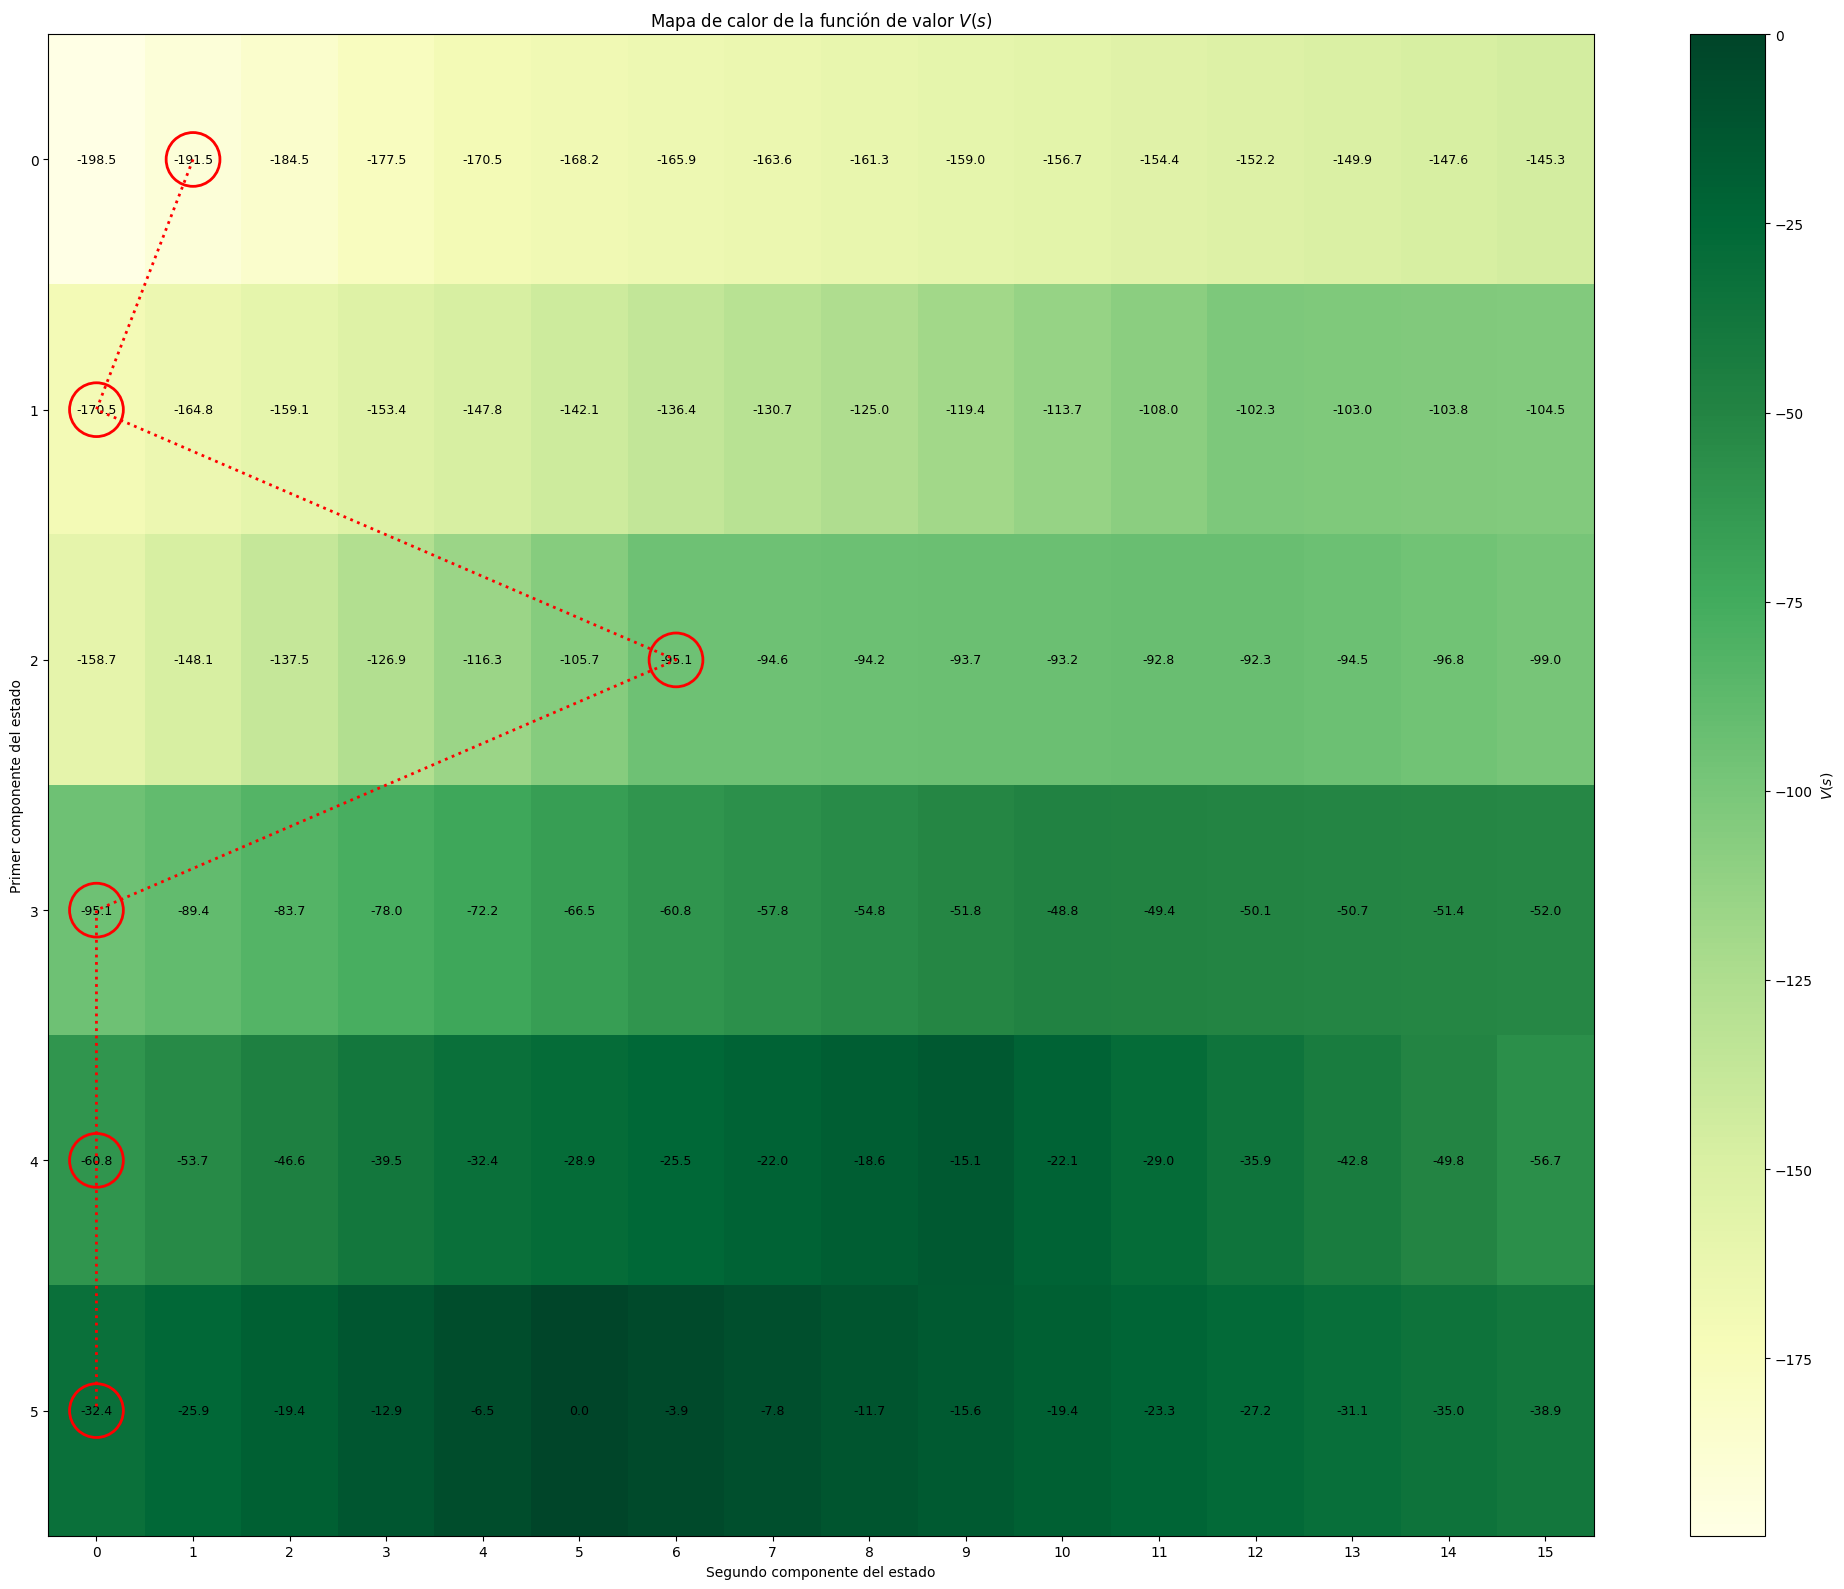


Value Iteration


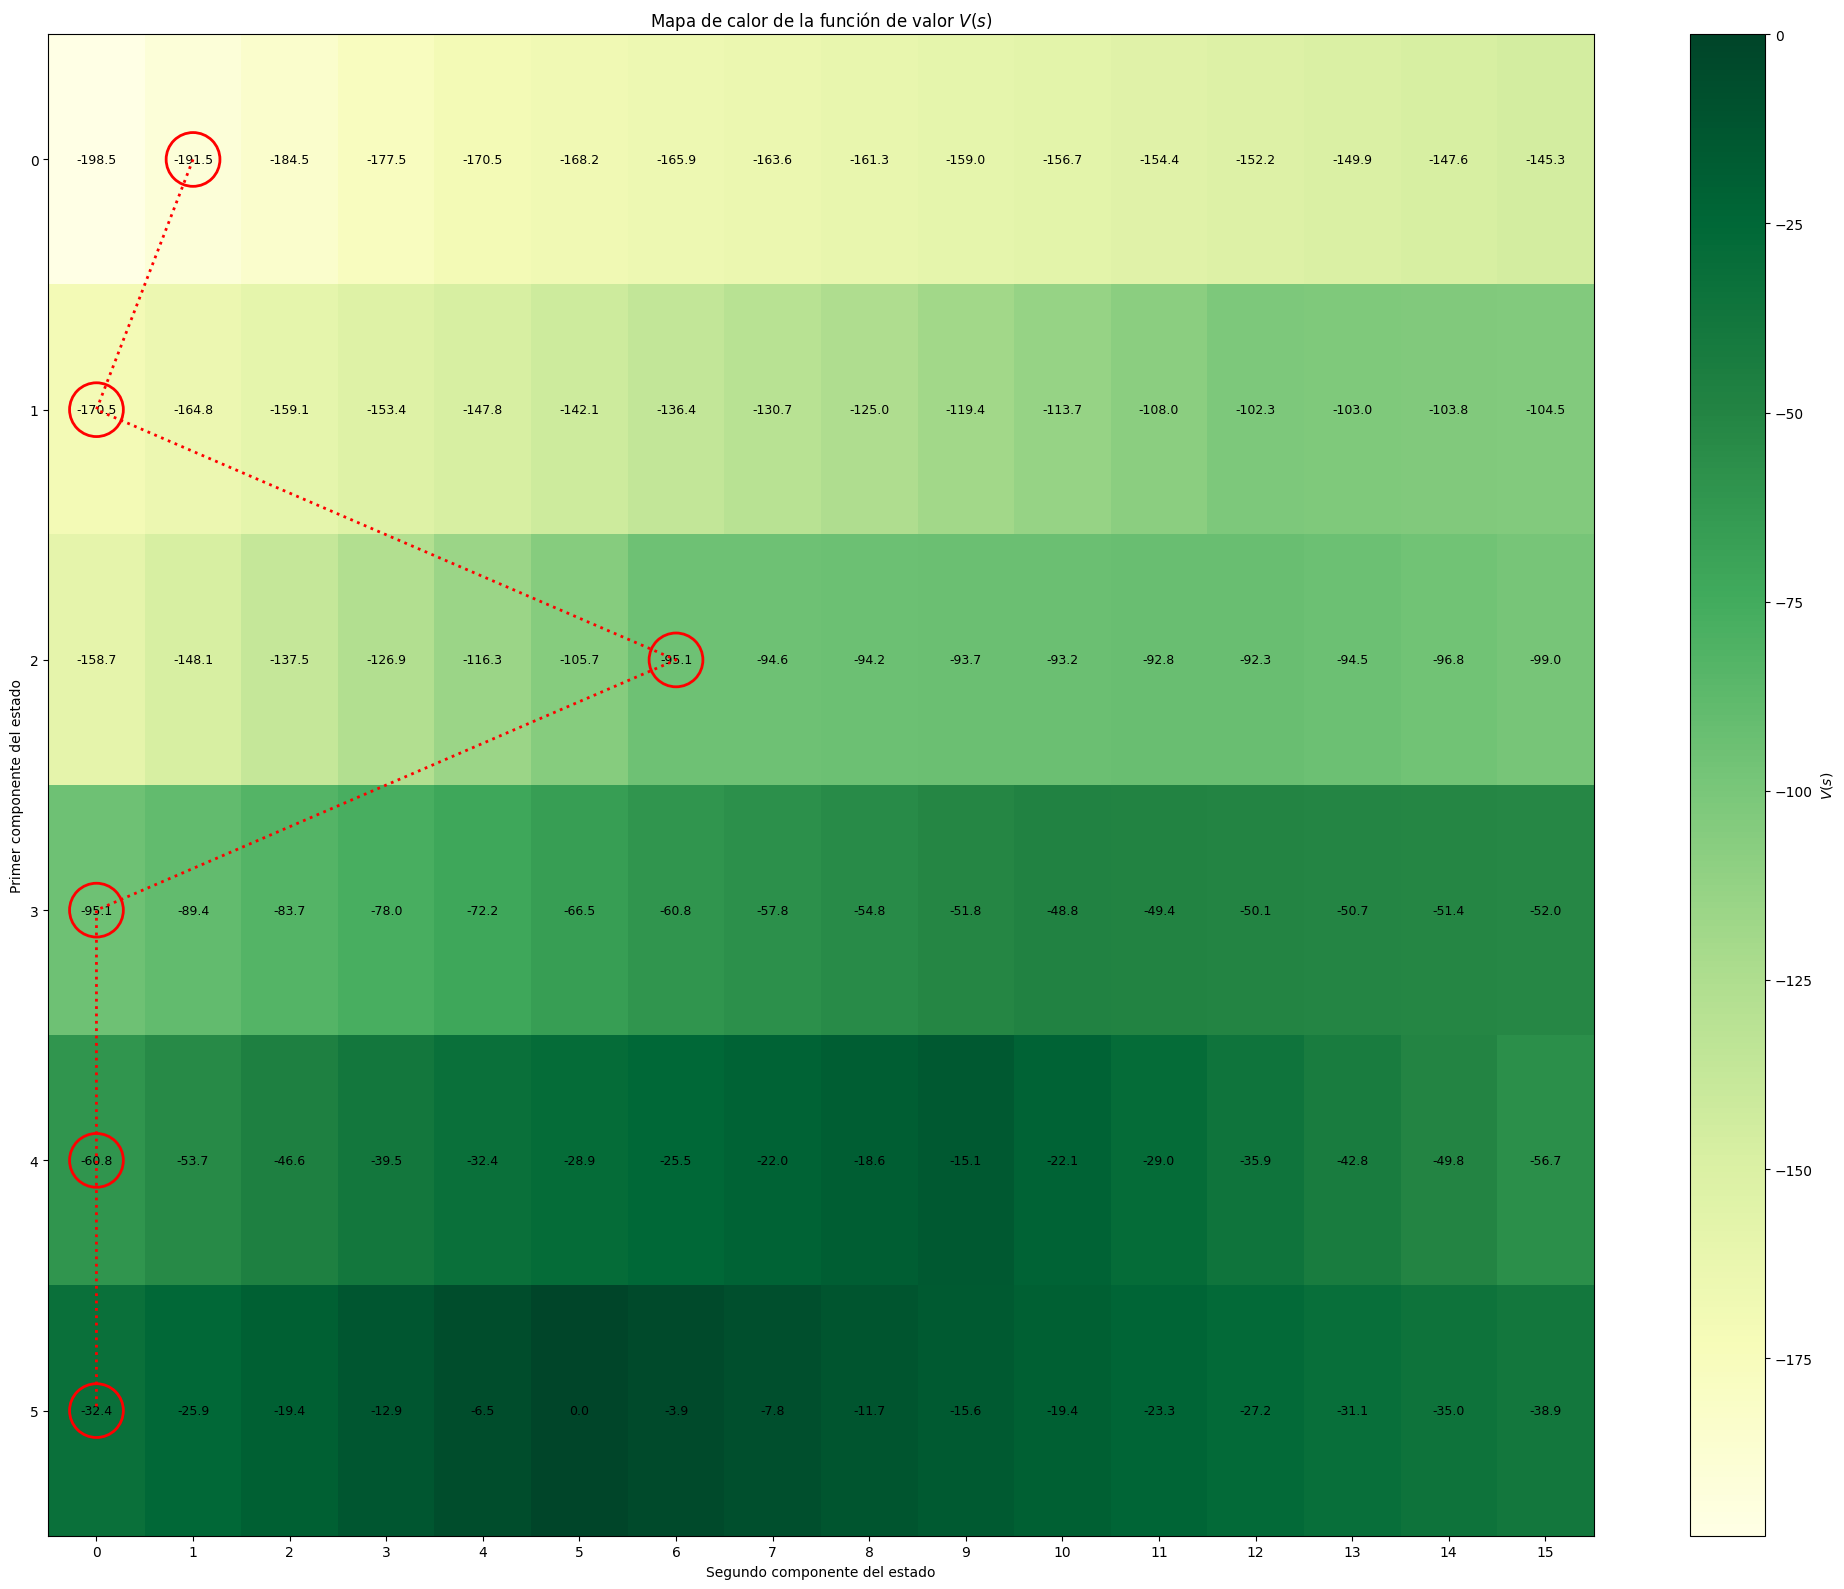

In [175]:
# ============================================================================
# Visualización condicional de V(s) para cada método aplicado
# ============================================================================
# Se muestran mapas de calor solo si el número de ítems (env.n) es razonable.
# Esto evita congestión visual en instancias grandes.
# ============================================================================

if env.capacity <= 15:

    # ----------------------------------------------------------------------
    # Evaluación de política heurística
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    value_states_visual(env, V, propose_policy)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    value_states_visual(env, V_star, star_policy)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    value_states_visual(env, V_opt, opt_policy)
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


#### Policy

Policy Evaluation


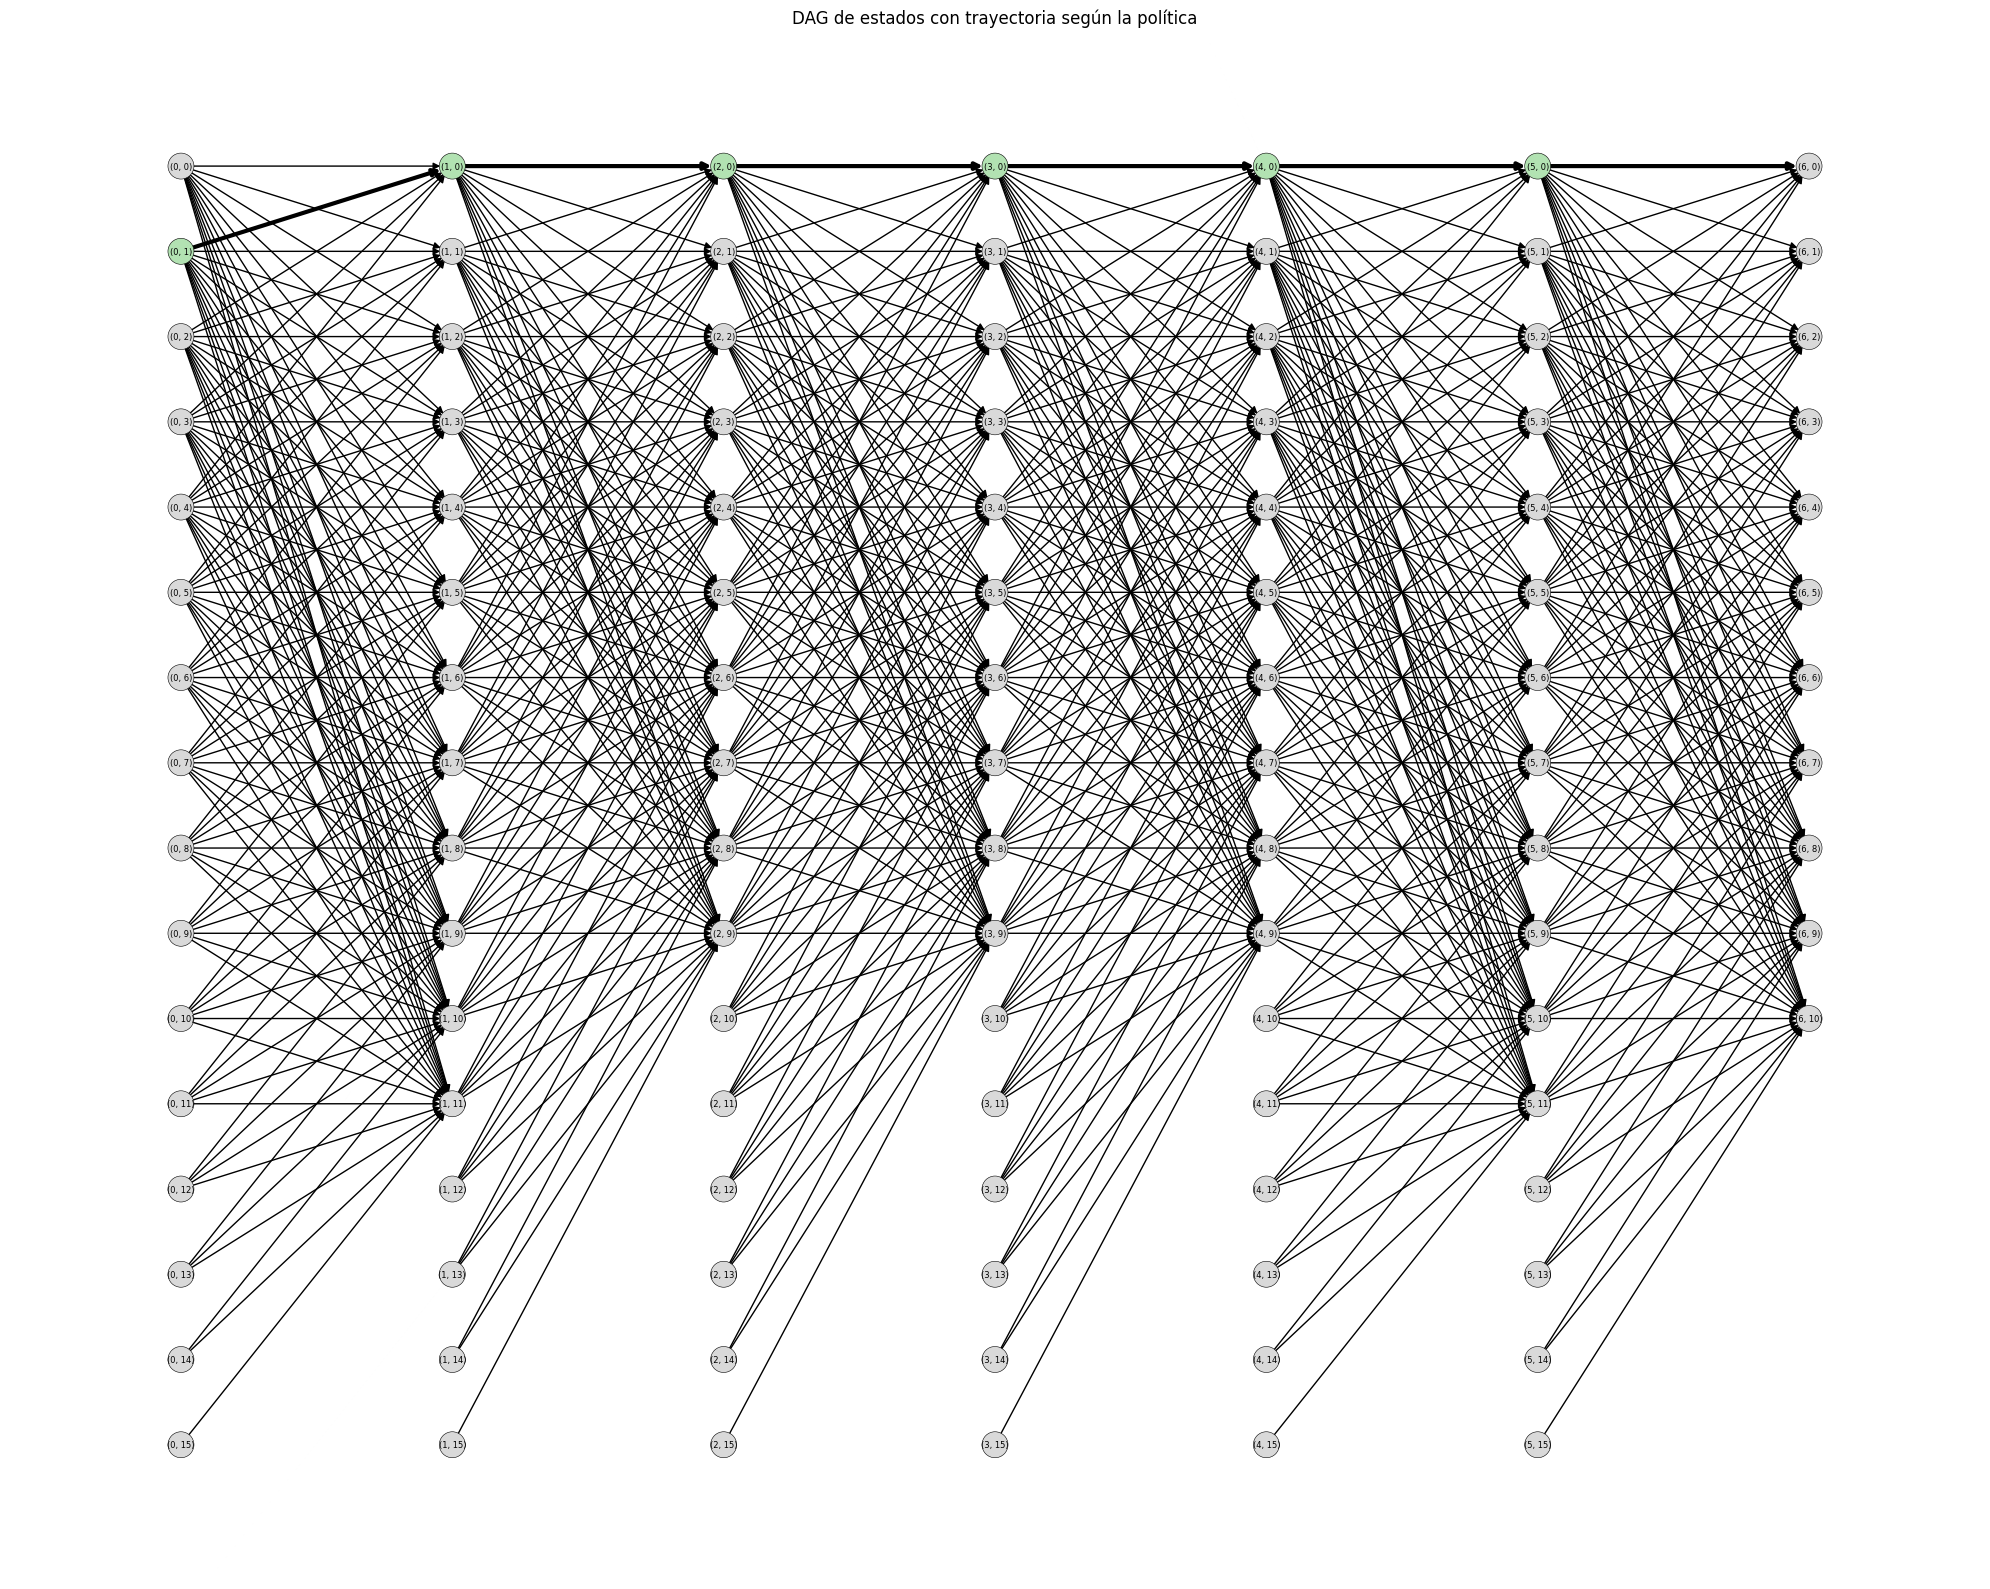


Policy Iteration


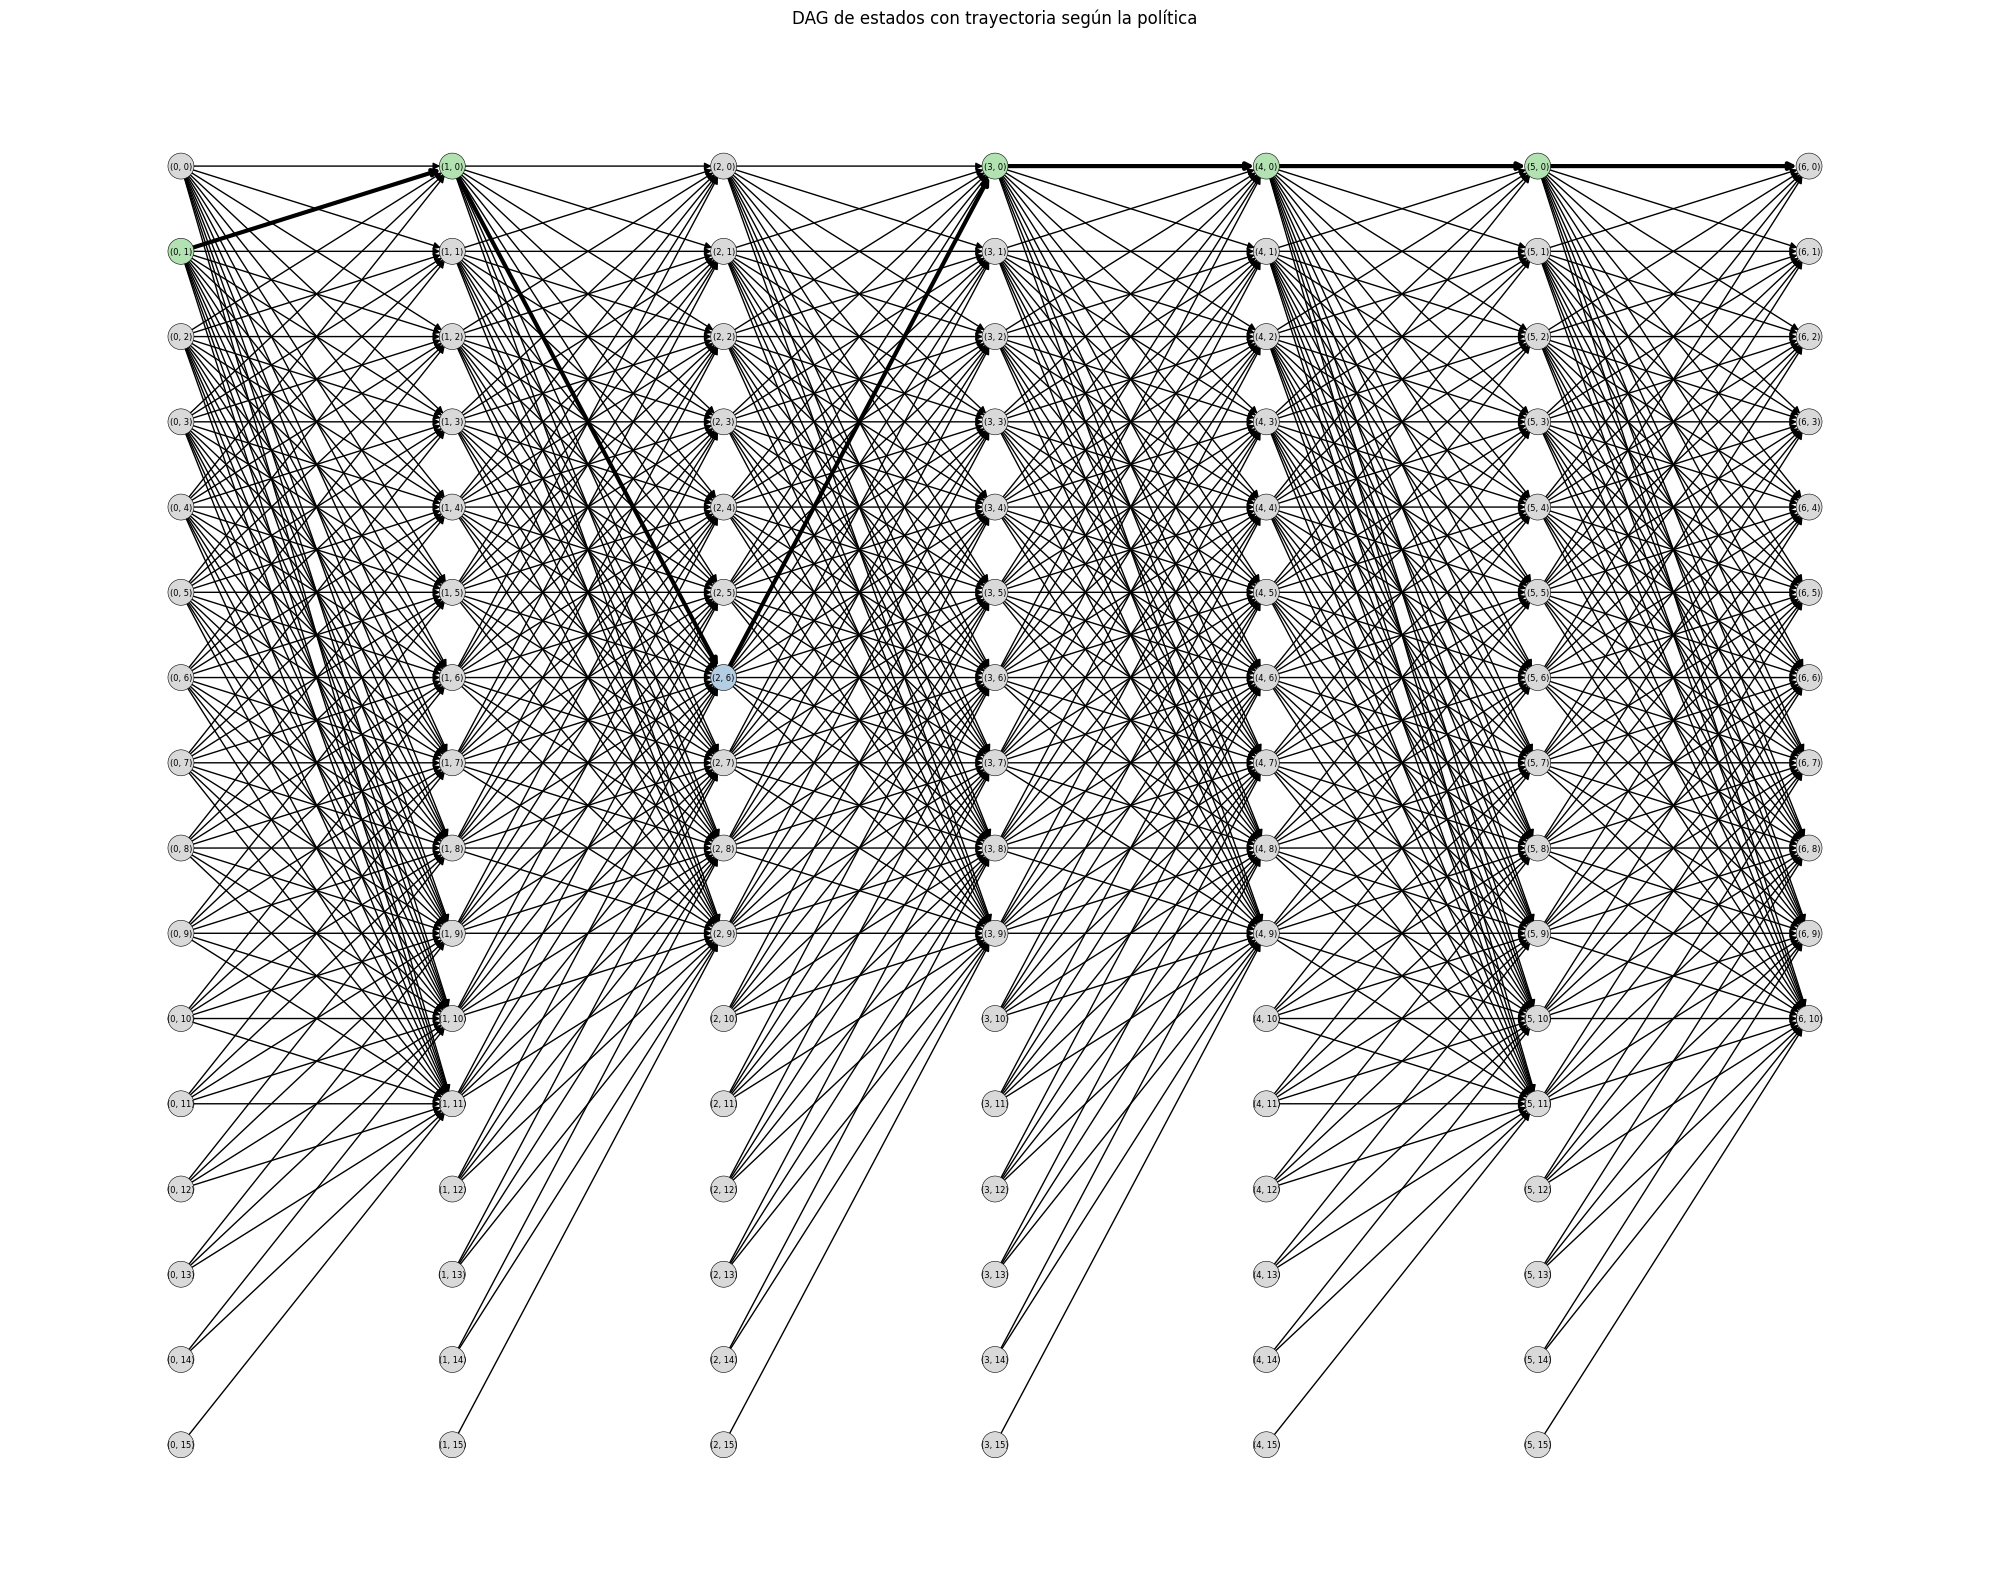


Value Iteration


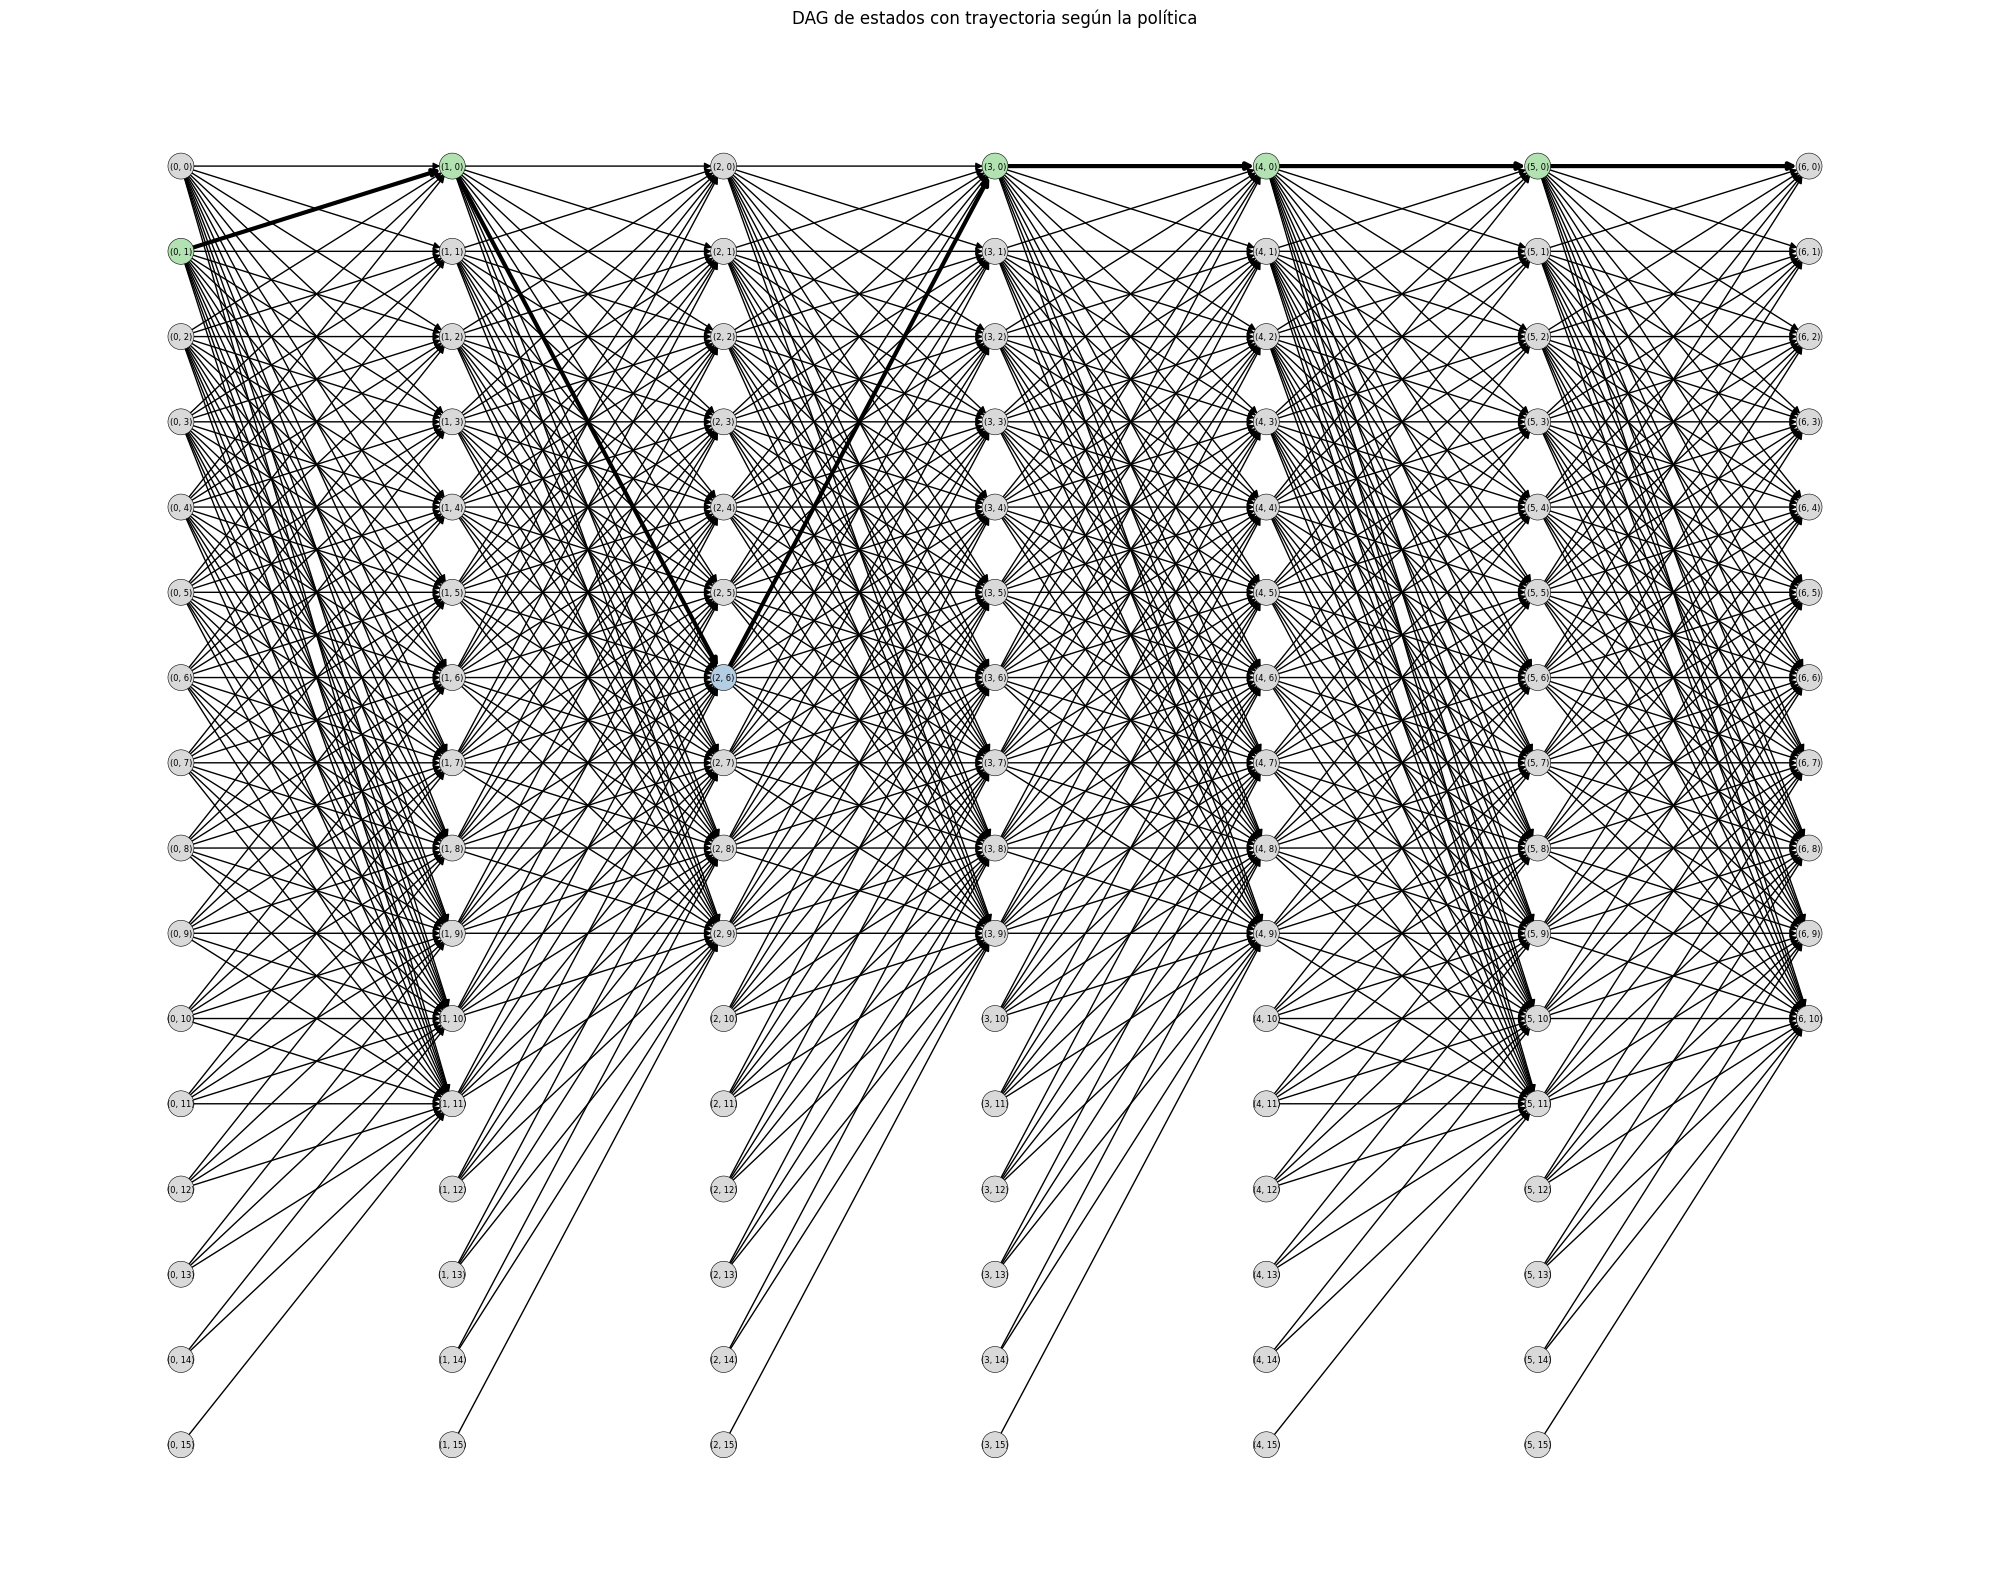

In [176]:
# ============================================================================
# Visualización condicional del DAG de decisiones para cada política evaluada
# ============================================================================
# Dibuja el grafo dirigido de estados con la trayectoria tomada por:
#   • Política heurística
#   • Iteración de políticas
#   • Iteración de valores
# Solo se activa para instancias pequeñas (n ≤ 20).
# ============================================================================

if env.capacity <= 15:

    # ----------------------------------------------------------------------
    # Política heurística: tomar cuando sea legal
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    draw_policy_dag(env, propose_policy, initial_state=(0, env.start_inventory))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    draw_policy_dag(env, star_policy, initial_state=(0, env.start_inventory))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    draw_policy_dag(env, opt_policy, initial_state=(0, env.start_inventory))
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


## Heurísticas

### EOQ

**¿Para qué sirve?**
Elegir un tamaño de pedido \$Q^\*\$ que minimiza el costo total anual de ordenar y mantener inventario cuando la demanda es conocida y no se permiten faltantes.


**Parámetros básicos**

* \$D\$: demanda total anual (u horizonte elegido).
* \$K\$: costo fijo por pedido (setup).
* \$h\$: costo de mantener 1 unidad en inventario por año (misma unidad de tiempo que \$D\$).
* \$L\$: lead time (años o fracción compatible con \$D\$).
* \$d = D / \text{(unidades de tiempo en el año)}\$: tasa de consumo.

**Fórmulas clave**

Tamaño de lote económico:
\$Q^\* = \sqrt{\frac{2 D K}{h}}\$

Punto de pedido (cuándo reordenar):
\$R = d \cdot L\$

Costo total mínimo (orden + mantenimiento, sin costo unitario):
\$TC(Q^\*) = \sqrt{2 D K h}\$

Inventario promedio en ciclo EOQ: \$Q^\*/2\$.

**Ciclo EOQ (intuición)**

Inventario sube a \$Q^\*\$ cuando llega un pedido, luego cae linealmente a 0 mientras consumes. Cuando el inventario baja a \$R\$, colocas un nuevo pedido; llega justo cuando ibas a quedar en 0, evitando faltantes.

**Algoritmo EOQ**

1. Calcula \$Q^\*\$ y \$R\$.
2. Inicializa inventario \$I = I\_0\$.
3. Repite mientras haya horizonte:

   * Si \$I \le R\$: emitir pedido por \$Q^\*\$ (llega tras \$L\$).
   * Avanza el tiempo; cuando llegue el pedido, suma \$Q^\*\$ a \$I\$.
   * Cada unidad de tiempo descuenta demanda \$d\$ de \$I\$.
   * Asegura \$I \ge 0\$ (si proyectas negativo antes de llegada, pide antes o ajusta \$R\$).

**Variante discreta por períodos (cuando demanda cambia por período)**

Para datos tabulares \$d\_t\$:

1. Ordena períodos \$M = {1,\dots,n}\$.
2. Calcula \$EOQ\$ (puedes usar \$D = \sum\_t d\_t\$ y costos promedio para aproximar).
3. Desde el período actual:

   * Acumula demanda futura hasta que la suma \$\ge EOQ\$ (o llegues al fin del horizonte).
   * Produce en el período inicial lo que falte para cubrir esa demanda acumulada (dado inventario disponible).
   * Consume período a período; sin faltantes (si se proyecta negativo, incrementa la producción inicial del bloque).
   * Salta al siguiente período no cubierto y repite.


In [177]:
import math

def heuristica_eoq(M, d, I_0, EOQ, debug=False):
    """
    Heurística tipo EOQ / lot-sizing por agrupación de períodos.
    Produce en el período t_ini lo necesario para cubrir demanda acumulada
    de un bloque de períodos hasta alcanzar EOQ (o fin de horizonte), usando
    inventario disponible. Sin faltantes (se ajusta producción si ocurre).

    Parámetros
      M     : lista ordenada de períodos (índices).
      d     : dict[t] demanda en t.
      I_0   : inventario inicial antes del primer período.
      EOQ   : tamaño económico de lote deseado (umbral de demanda acumulada).
      debug : imprime trazas si True.

    Devuelve
      obj_lp         : ***no definido en esta función*** (placeholder; calc. externo).
      produccion     : dict[t] unidades producidas en t (solo al inicio de lote).
      inventario_ini : dict[t] inventario al inicio de t (antes de producir/consumir en t).
      inventario_fin : dict[t] inventario al final de t (después de consumo).
    """

    n = len(M)
    produccion     = {t: 0 for t in M}
    inventario_ini = {}   # inv al inicio de t (antes de producir en lote que arranca en t)
    inventario_fin = {}   # inv al final de t (para costos de holding)

    inv = I_0  # inventario disponible al inicio del período actual
    idx = 0

    while idx < n:
        t_ini = M[idx]

        # inventario inicial del período donde inicia el lote
        inventario_ini[t_ini] = inv

        # agrupar períodos hasta alcanzar EOQ o fin del horizonte
        demanda_acum = 0
        k = 0
        while idx + k < n and demanda_acum < EOQ:
            demanda_acum += d[M[idx + k]]
            k += 1
        # al salir: bloque = períodos idx .. idx+k-1; demanda_acum cubre ese bloque

        # producir en t_ini lo faltante para cubrir el bloque dado el inventario actual
        q = max(0, demanda_acum - inv)
        produccion[t_ini] += q
        inv += q  # producción disponible de inmediato

        if debug:
            print(f"\n[Lote inicia en {t_ini}] inv_ini={inventario_ini[t_ini]}  demanda_lote={demanda_acum}  prod={q}")

        # consumir demanda período a período dentro del bloque
        for j in range(k):
            t_cur = M[idx + j]

            # registrar inventario inicial en períodos intermedios del bloque (no se produce)
            if j > 0:
                inventario_ini[t_cur] = inv

            inv -= d[t_cur]

            # no se permiten faltantes: si ocurren, aumentar producción retroactivamente en t_ini
            if inv < 0:
                faltante = -inv
                if debug:
                    print(f"  Ajuste: faltante {faltante} detectado en {t_cur}; aumentando prod en {t_ini}.")
                produccion[t_ini] += faltante
                inv = 0  # después del ajuste quedamos en cero (cubre exactamente)

            inventario_fin[t_cur] = inv
            if debug:
                print(f"    Fin {t_cur}: inv_fin={inv}")

        # avanzar al siguiente bloque
        idx += k

    # asegurar claves completas en las estructuras de salida
    for t in M:
        inventario_ini.setdefault(t, 0)
        inventario_fin.setdefault(t, 0)
        produccion.setdefault(t, 0)

    # NOTA: obj_lp no se calcula aquí; debe computarse con los vectores de costo.
    return obj_lp, produccion, inventario_ini, inventario_fin



Tiempo de ejecución: 0.000049 s
FO (valor total): 190.80 (Producción) + 99.93 (Inventario) = 290.73
Cantidad de toneladas producidas (valor total): 30.
Cantidad de toneladas en inventario (valor total): 32.


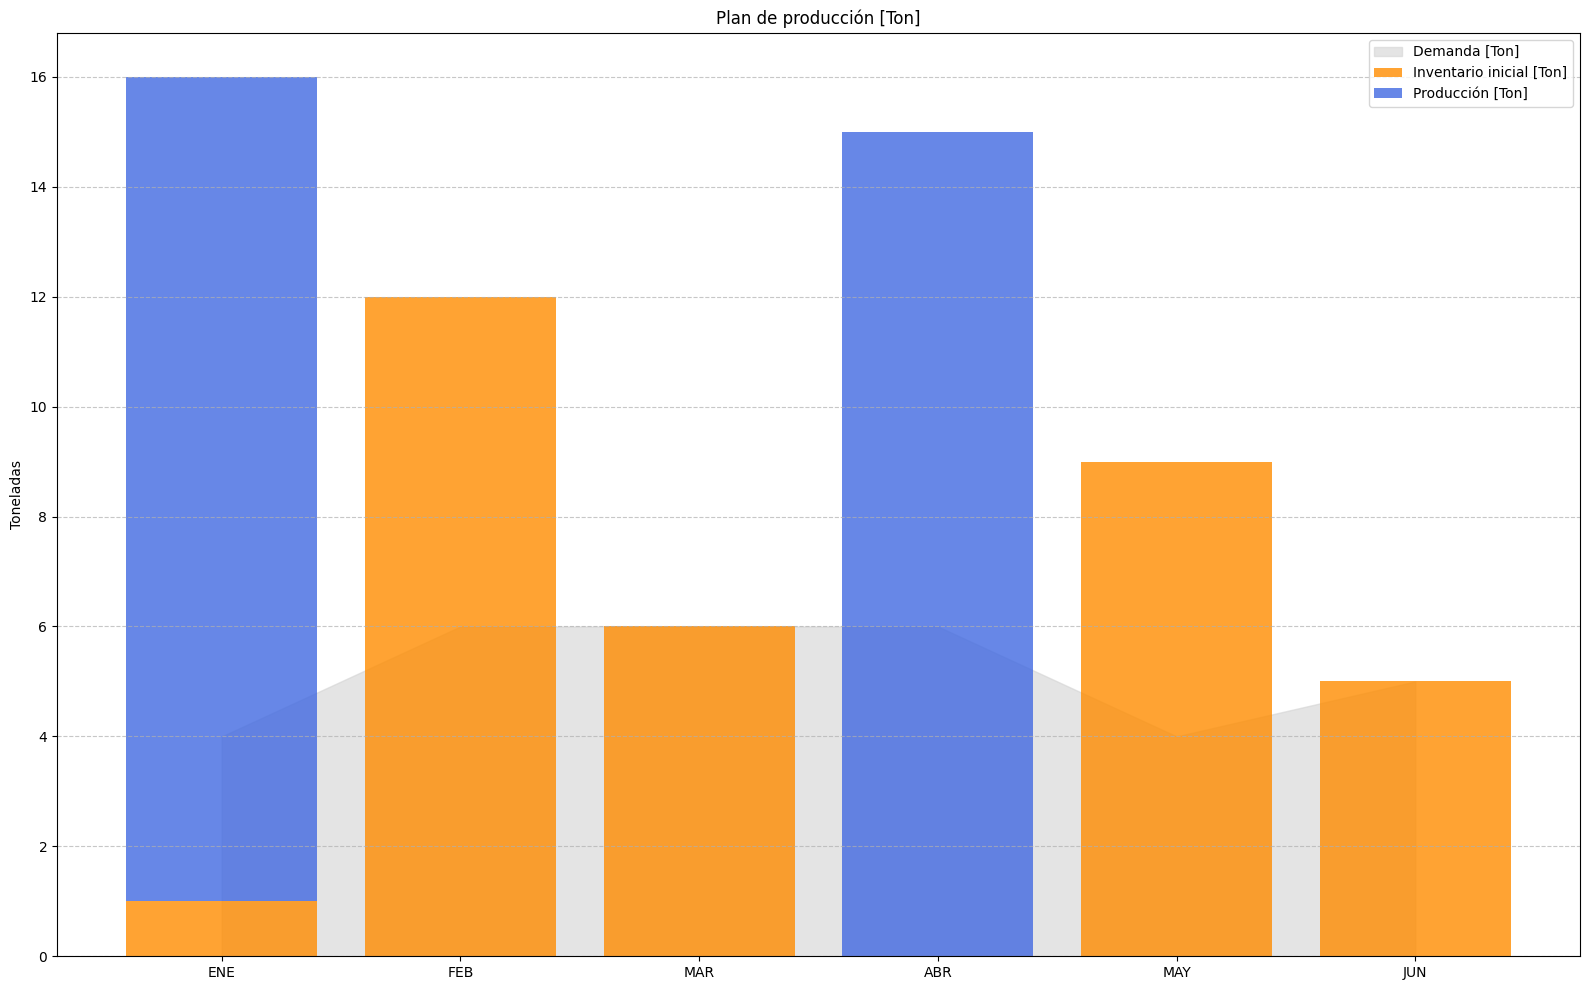

In [178]:
# ============================================================================
# Calcular EOQ aproximado a partir de demanda total y costos promedio
# ============================================================================
D_total = sum(d[t] for t in M)                 # demanda total
H_prom  = sum(h[t] for t in M) / len(M)        # holding promedio
C_prom  = sum(c[t] for t in M) / len(M)        # producción promedio
EOQ = math.sqrt(2 * D_total * C_prom / H_prom) # fórmula EOQ clásica

# ============================================================================
# Ejecutar heurística EOQ
# ============================================================================
t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_eoq(M, d, I_0, EOQ)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# ============================================================================
# Costos (holding usa inventario_fin)
# ============================================================================
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario_fin[t] * h[t] for t in M)
obj_lp = cost_produccion + cost_inventario  # recalculado aquí

# ============================================================================
# Reporte
# ============================================================================
print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario_fin.values())}.')
plot_plan_produccion(M, d, produccion, inventario)

# ============================================================================
# Registrar resultados
# ============================================================================
resultados.append({
    "Método"             : "EOQ",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario_fin.values()),
    "Tiempo (s)"         : elapsed
})


### Política (s, S)


**Idea:** Cada período revisas el inventario inicial. Si cae por debajo de $s$, repones hasta $S$. Además, aseguras cubrir la demanda del período (no se permiten faltantes).

**Parámetros:**
$s$ = punto de disparo.
$S$ = nivel objetivo tras reponer (idealmente $S > s$).
$d_t$ = demanda en el período $t$.
$I_0$ = inventario inicial.

**Pasos por período $t$:**

1. Observa $I_t^{ini}$.
2. Si $I_t^{ini} < s$: $q_t = S - I_t^{ini}$; de lo contrario $q_t = 0$.
3. Cobertura de demanda: si $I_t^{ini} + q_t < d_t$, incrementa $q_t$ en $d_t - (I_t^{ini} + q_t)$.
4. Inventario final: $I_t^{fin} = I_t^{ini} + q_t - d_t$.
5. Sin faltantes: si $I_t^{fin} < 0$, aumenta $q_t$ en el faltante y fija $I_t^{fin} = 0$.
6. Registra $q_t$, $I_t^{ini}$, $I_t^{fin}$. Usa $I_t^{fin}$ como inventario inicial del siguiente período.

**Costo típico en el horizonte $M$:**

$$
C = \sum_{t \in M} c_t\, q_t \;+\; \sum_{t \in M} h_t\, I_t^{fin}
$$



In [179]:
def heuristica_ss(M, d, I_0, s, S, debug=False):
    """
    Heurística (s, S) con cobertura de demanda del período.
    Si inventario < s, reponer hasta S; si no, no producir.
    Luego asegurar que la producción cubra d[t] (sin faltantes).
    
    Params:
      M : lista ordenada de períodos.
      d : dict[t] demanda en t.
      I_0 : inventario inicial.
      s, S : parámetros de política (s<S).
      debug : trazas opcionales.
    
    Returns:
      obj_lp (placeholder, calc. externo),
      produccion[t],
      inventario_ini[t],
      inventario_fin[t].
    """
    produccion     = {t: 0 for t in M}
    inventario_ini = {}
    inventario_fin = {}

    inv = I_0  # inventario al inicio del período actual

    for t in M:
        # inventario inicial (para graficar / reporte)
        inventario_ini[t] = inv

        # regla (s,S): ¿reponer?
        if inv < s:
            q = S - inv
        else:
            q = 0

        # garantizar cobertura de demanda del período (no faltantes)
        if inv + q < d[t]:
            q += d[t] - (inv + q)

        produccion[t] = q
        inv += q  # producción disponible antes de satisfacer demanda

        # consumir demanda
        inv -= d[t]

        # protección numérica: no negativos
        if inv < 0:
            if debug:
                print(f"Ajuste tardío en {t}: faltante {-inv}; incrementando producción.")
            produccion[t] += -inv
            inv = 0

        inventario_fin[t] = inv

        if debug:
            print(f"t={t} inv_ini={inventario_ini[t]} prod={produccion[t]} demanda={d[t]} inv_fin={inventario_fin[t]}")

    # obj_lp no se computa aquí; calcúlalo externamente con costos.
    return obj_lp, produccion, inventario_ini, inventario_fin



Tiempo de ejecución: 0.000029 s
FO (valor total): 224.12 (Producción) + 13.57 (Inventario) = 237.69
Cantidad de toneladas producidas (valor total): 31.0.
Cantidad de toneladas en inventario (valor total): 5.0.


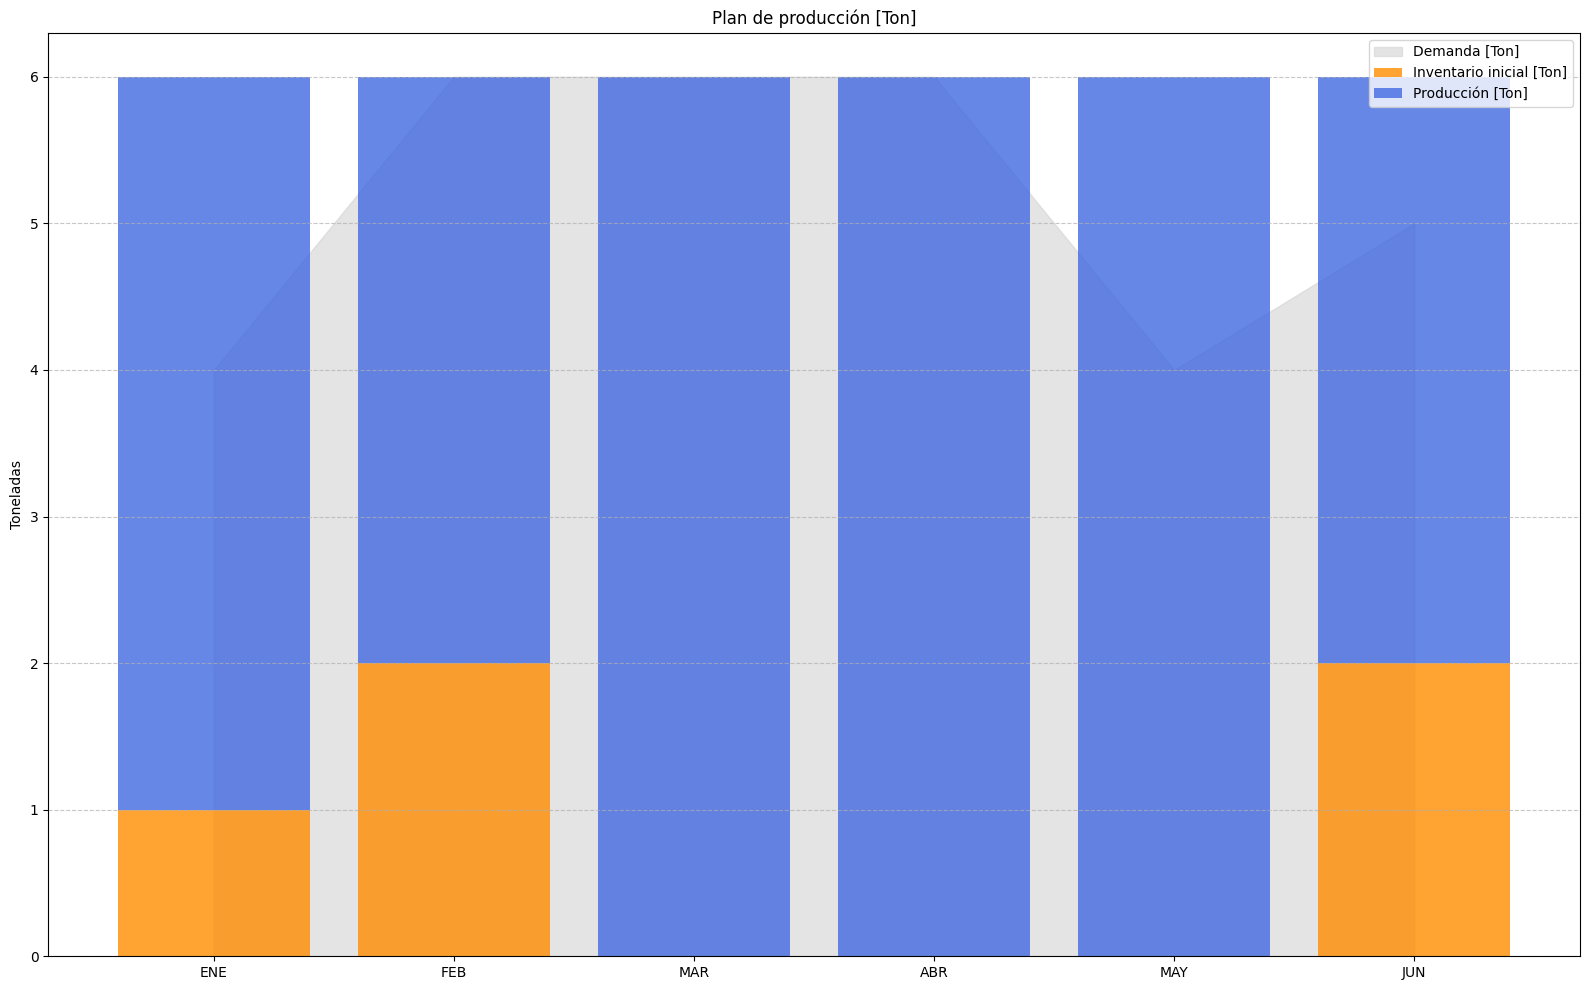

In [180]:
# ============================================================================
# Parámetros de política (s,S)
# ============================================================================
s = max(d.values())          # umbral de disparo: si inv < s, se repone
S = 1.5 * min(d.values())    # nivel objetivo tras reponer (ojo: puede quedar S < s)

# ============================================================================
# Ejecutar heurística (s,S)
# ============================================================================
t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_ss(M, d, I_0, s, S)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# ============================================================================
# Costos (holding usando inventario inicial; usar inventario_fin si corresponde)
# ============================================================================
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario[t] * h[t] for t in M)
obj_lp = cost_produccion + cost_inventario

# ============================================================================
# Reporte
# ============================================================================
print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario (valor total): {sum(inventario.values())}.')
plot_plan_produccion(M, d, produccion, inventario)

# ============================================================================
# Registrar resultados
# ============================================================================
resultados.append({
    "Método"             : "(s,S)",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario.values()),
    "Tiempo (s)"         : elapsed
})


### Silver-Meal

**Idea:** Decidir cuántos períodos cubrir con un solo lote. Comienzas en un período $i$, calculas el costo promedio por período de producir lo necesario para cubrir $i..j$, y vas extendiendo $j$ mientras ese costo promedio **no aumente**. Cuando sube, te quedas con el último $j$ “bueno”, produces al inicio $i$ lo que falte para cubrir ese bloque y avanzas al siguiente período no cubierto. No se permiten faltantes: si en la ejecución el inventario llegara a negativo, aumentas la producción inicial del bloque.


**Parámetros:**
$M$: períodos ordenados.
$d_t$: demanda en $t$.
$h_t$: costo de mantener inventario al final de $t$.
$K$: costo de preparación (setup) por lote.
$I_0$: inventario inicial.


**Evaluar un bloque $i..j$:**
Demanda acumulada $D_{i:j} = \sum_{u=i}^j d_u$.
Producción necesaria $q_i = \max(0, D_{i:j} - I_i^{ini})$.
Inventario proyectado al final de cada período $u$ dentro del bloque: $I_u^{proj} = I_i^{ini} + q_i - \sum_{v=i}^u d_v$ (truncar a 0 si negativo; sin faltantes).
Costo holding del bloque: $\sum_{u=i}^j h_u I_u^{proj}$.
Costo total bloque: $K + \text{holding}$.
Costo promedio: $\overline{C}_{i:j} = (K + \sum_{u=i}^j h_u I_u^{proj}) / (j - i + 1)$.


**Regla Silver-Meal:** Extiende $j$ de forma incremental. Mientras $\overline{C}_{i:j} \le \overline{C}_{i:j-1}$, sigues extendiendo. Cuando sube, detienes y usas el último $j$ aceptado.


**Pseudocódigo (resumido, sin código ejecutable):**

1. Fija índice de inicio $i$ (primer período no cubierto); $I_i^{ini}$ es inventario disponible.
2. Para $j = i, i+1, \dots$:

   * Calcula $D_{i:j}$, $q_i$, inventarios proyectados y costo promedio $\overline{C}_{i:j}$.
   * Si $j = i$ o $\overline{C}_{i:j} \le \overline{C}_{i:j-1}$: guarda $j$ como mejor.
   * Si $\overline{C}_{i:j} > \overline{C}_{i:j-1}$: detén búsqueda.
3. Produce $q_i$ en período $i$ para cubrir $i..j^\*$ (último aceptado).
4. Simula consumos reales período a período dentro del bloque; si inventario cae <0 en algún período, aumenta producción inicial $q_i$ en el faltante y fija inventario en 0 (sin faltantes).
5. Avanza $i \leftarrow j^\* + 1$ y repite hasta fin de $M$.


**Costo total en el horizonte:**
$C = \sum_{\text{lotes}} K + \sum_{t \in M} h_t I_t^{fin} + \sum_{t \in M} c_t q_t$ (incluye costo unitario si lo registras; en el cálculo de decisión Silver-Meal, $c_t$ suele omitirse porque no cambia con la longitud del bloque, pero puedes agregarlo al reporte final).


In [181]:
def heuristica_silver_meal(M, c, h, d, I_0, debug=False):
    """
    Heurística Silver-Meal (lot-sizing aproximado).
    Extiende lote desde período i mientras el costo promedio (setup+holding)/período
    no aumente. Ajusta producción para evitar faltantes.

    Parámetros:
      M   : lista ordenada de períodos.
      c,h : dict[t] costos de producción y holding.
      d   : dict[t] demanda por período.
      I_0 : inventario inicial antes del primer período.
      debug : trazas opcionales.

    Retorna:
      obj_lp (placeholder; calc. externo),
      produccion[t], inventario_ini[t], inventario_fin[t].
    """
    # Setup aproximado (no provisto en datos): múltiplo del costo medio p/ período
    K = (sum(c[t] for t in M) / len(M)) * 5.0

    n = len(M)
    produccion     = {t: 0 for t in M}
    inventario_ini = {}
    inventario_fin = {}

    inv = I_0   # inventario disponible al inicio del período actual
    idx = 0

    while idx < n:
        i      = idx
        t_ini  = M[i]
        inv_start = inv

        # inventario inicial en el período que inicia el lote
        inventario_ini[t_ini] = inv_start

        # explorar extensión del lote j = i..n-1
        prev_avg = float("inf")
        best_len = 1
        cum_dem  = 0

        for j in range(i, n):
            t_j = M[j]
            cum_dem += d[t_j]  # demanda acumulada i..j

            # prod neta requerida si cubro i..j
            net_prod = max(0, cum_dem - inv_start)

            # proyectar inventario período a período para costo holding
            inv_tmp   = inv_start + net_prod
            hold_cost = 0
            for r in range(i, j + 1):
                inv_tmp -= d[M[r]]
                if inv_tmp < 0:
                    inv_tmp = 0  # sin backorders en proyección
                hold_cost += inv_tmp * h[M[r]]

            total_cost = K + hold_cost
            avg_cost   = total_cost / (j - i + 1)

            if debug:
                print(f"Eval lote {t_ini}..{t_j}: total={total_cost:.2f}, avg={avg_cost:.2f}")

            # regla Silver-Meal: parar cuando aumenta costo promedio
            if avg_cost <= prev_avg:
                best_len = j - i + 1
                prev_avg = avg_cost
            else:
                break

        # lote elegido: i .. i+best_len-1
        lote_len = best_len
        lot_dem  = sum(d[M[r]] for r in range(i, i + lote_len))
        q        = max(0, lot_dem - inv_start)

        # producir en período inicial
        produccion[t_ini] += q
        inv += q

        if debug:
            print(f"\n[Lote definitivo {t_ini} cubre {lote_len} períodos] prod={q} inv_start={inv_start}")

        # consumir dentro del lote y registrar inventarios
        for r in range(i, i + lote_len):
            t_r = M[r]
            if r > i:
                inventario_ini[t_r] = inv  # arrastre

            inv -= d[t_r]
            if inv < 0:
                # ajuste anti-faltantes (retroproduce en t_ini)
                faltante = -inv
                produccion[t_ini] += faltante
                inv = 0
                if debug:
                    print(f"  Ajuste faltante en {t_r}: +{faltante} prod en {t_ini}.")

            inventario_fin[t_r] = inv

        # siguiente bloque
        idx += lote_len

    # completar claves faltantes (por seguridad)
    for t in M:
        inventario_ini.setdefault(t, 0)
        inventario_fin.setdefault(t, 0)
        produccion.setdefault(t, 0)

    # obj_lp no se calcula aquí; hazlo con costos externos.
    return obj_lp, produccion, inventario_ini, inventario_fin



Tiempo de ejecución: 0.000044 s
FO (valor total): 194.55 (Producción) + 64.28 (Inventario) = 258.83
Cantidad de toneladas producidas (valor total): 30.
Cantidad de toneladas en inventario fin (valor total): 22.


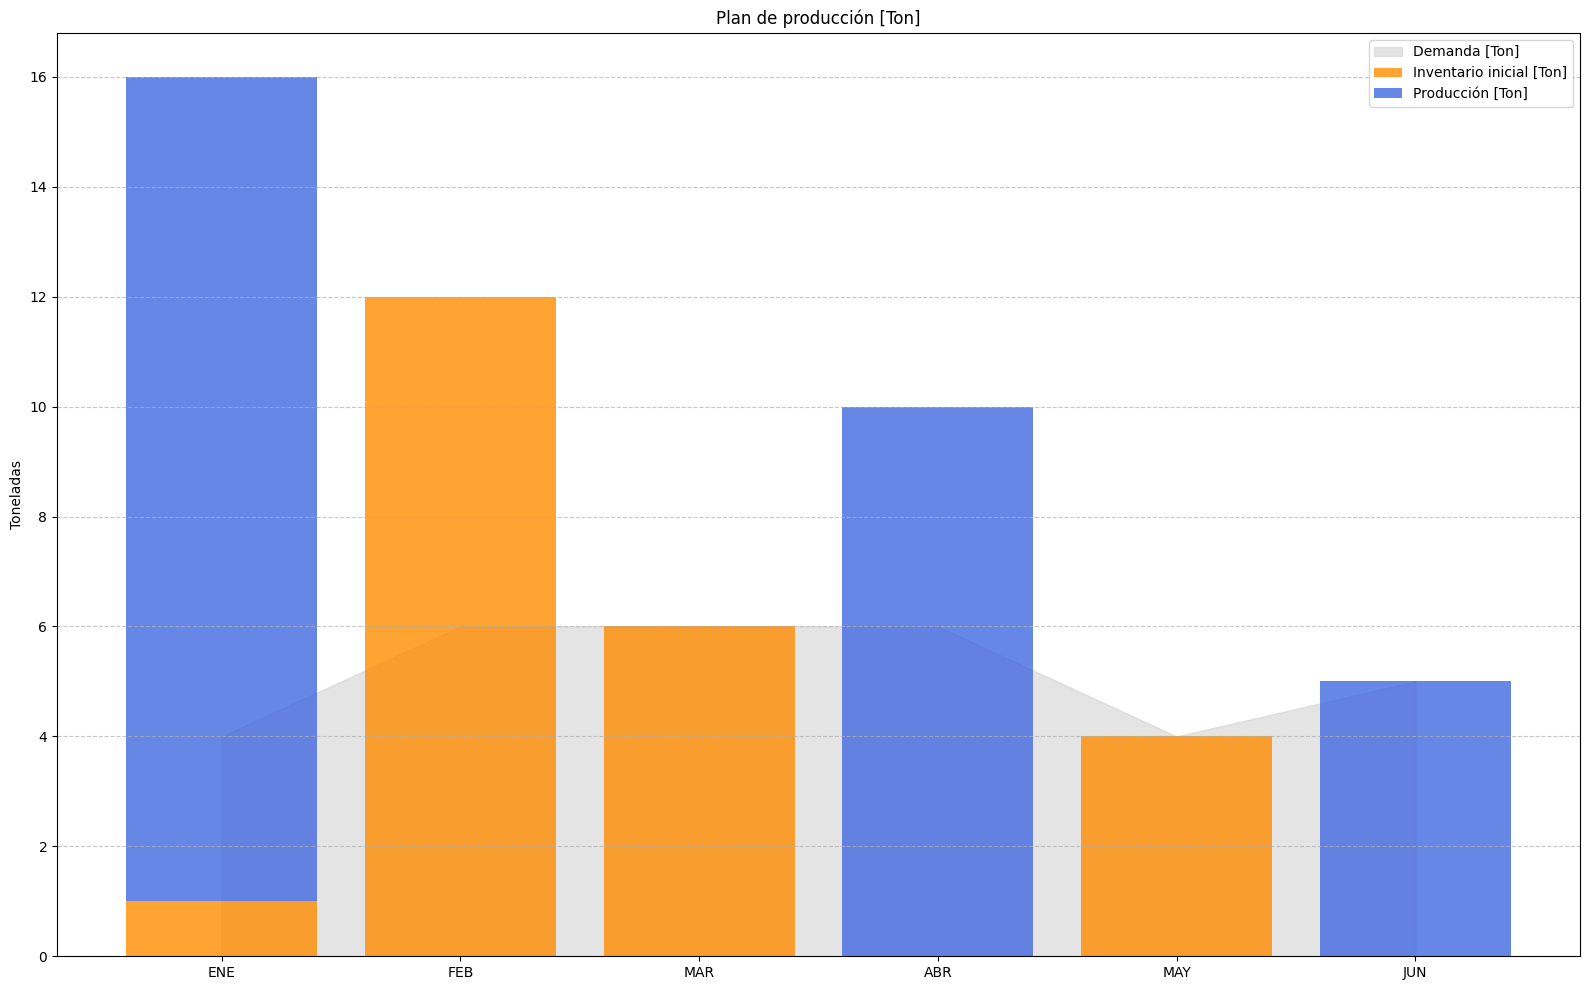

In [182]:
# ============================================================================
# Ejecutar heurística Silver-Meal y registrar resultados
# ============================================================================
t0 = time.perf_counter()
obj_lp, produccion, inventario, inventario_fin = heuristica_silver_meal(M, c, h, d, I_0)
elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# Costos (recalculamos desde salidas de la heurística)
cost_produccion = sum(produccion[t] * c[t] for t in M)
cost_inventario = sum(inventario_fin[t] * h[t] for t in M)  # holding sobre inventario final
obj_lp = cost_produccion + cost_inventario

# Reporte
print(f'FO (valor total): {cost_produccion:.2f} (Producción) + {cost_inventario:.2f} (Inventario) = {obj_lp:.2f}')
print(f'Cantidad de toneladas producidas (valor total): {sum(produccion.values())}.')
print(f'Cantidad de toneladas en inventario fin (valor total): {sum(inventario_fin.values())}.')
plot_plan_produccion(M, d, produccion, inventario)

# Registrar
resultados.append({
    "Método"             : "Silver-Meal",
    "Costo Total"        : obj_lp,
    "Costo producir"     : cost_produccion,
    "Costo inventario"   : cost_inventario,
    "Ton pedidas (total)": sum(produccion.values()),
    "Inventario(total)"  : sum(inventario_fin.values()),
    "Tiempo (s)"         : elapsed
})


## Resultados

In [183]:
import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Costo Total", ascending=True, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

Costo Total  Costo producir  Costo inventario  \
Método                                                             
LP                      191.47          184.27              7.20   
Policy iteration        191.47          184.27              7.20   
Value iteration         191.47          184.27              7.20   
Policy evaluation       213.73          213.73              0.00   
(s,S)                   237.69          224.12             13.57   
Silver-Meal             258.83          194.55             64.28   
EOQ                     290.73          190.80             99.93   

                   Ton pedidas (total)  Inventario(total)  Tiempo (s)  
Método                                                                 
LP                                30.0                7.0    0.044320  
Policy iteration                  30.0                7.0    0.001052  
Value iteration                   30.0                7.0    0.003388  
Policy evaluation                 30.0                1.0    0.000304  
(s,S)                             31.0                5.0    0.000029  
Silver-Meal                       30.0               22.0    0.000044  
EOQ                               30.0               32.0    0.000049

In [184]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

Costo Total GAP (%)  Costo producir GAP (%)  \
Método                                                           
LP                               0.000                   0.000   
Policy iteration                 0.000                   0.000   
Value iteration                  0.000                   0.000   
Policy evaluation               11.626                  15.987   
(s,S)                           24.140                  21.626   
Silver-Meal                     35.180                   5.579   
EOQ                             51.841                   3.544   

                   Costo inventario GAP (%)  Ton pedidas (total) GAP (%)  \
Método                                                                     
LP                                    0.000                        0.000   
Policy iteration                     -0.000                        0.000   
Value iteration                      -0.000                        0.000   
Policy evaluation                  -100.000                        0.000   
(s,S)                                88.472                        3.333   
Silver-Meal                         792.778                        0.000   
EOQ                                1287.917                        0.000   

                   Inventario(total) GAP (%)  Tiempo (s) (x veces LP)  
Método                                                                 
LP                                     0.000                   1.0000  
Policy iteration                       0.000                   0.0237  
Value iteration                        0.000                   0.0764  
Policy evaluation                    -85.714                   0.0069  
(s,S)                                -28.571                   0.0006  
Silver-Meal                          214.286                   0.0010  
EOQ                                  357.143                   0.0011